In [1]:
import sys
sys.path.insert(0,'/home/xu.chao/cantera/build/python')
import cantera as ct
print(ct.__version__)

3.0.0a1


In [1]:
%config IPCompleter.use_jedi=False

import requests
import pprint
import sys
import json
import io
import copy
import ase.calculators.singlepoint
from ase.io.espresso import read_espresso_in, read_espresso_out
from ase.calculators.espresso import Espresso
from ase.io.espresso import read_fortran_namelist
import re
import pandas as pd
import scipy.optimize
import numpy as np
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.linear_model import LinearRegression
import statistics
from math import sqrt
from rmgpy.data.surface import MetalDatabase
import random
import os
import re
import matplotlib.pyplot as plt
import cantera as ct


GRAPHQL = 'http://api.catalysis-hub.org/graphql'

def fetch(query):
    return requests.get(
        GRAPHQL, {'query': query}
    ).json()['data']

In [2]:
query_str = """
            {reactions ( first: 200, reactants: , products: ) 
            {
            totalCount
            pageInfo {
              hasNextPage
              hasPreviousPage
              startCursor
              endCursor
            }
            edges {
              node {
                Equation
                sites
                id
                pubId
                dftCode
                dftFunctional
                reactants
                products
                facet
                chemicalComposition
                facet
                reactionEnergy
                activationEnergy
                surfaceComposition
                chemicalComposition
                reactionSystems {
                  name
                  energyCorrection
                  aseId
                }
              }
            }
            }}
            """

In [3]:
import cantera as ct
base_yml = '/work/westgroup/chao/sketches/cpox_sim/rmg_models_bm/base_original/base_modified.yaml'
gas = ct.Solution(base_yml, 'gas')
surf = ct.Interface(base_yml,'surface1', [gas])

/home/xu.chao/anaconda3/envs/rmg_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: StickingRate::validate: 
 Sticking coefficient is greater than 1 for reaction 'H(12) + X(1) <=> HX(21)'
 at T = 200.0

 Sticking coefficient is greater than 1 for reaction 'H(12) + X(1) <=> HX(21)'
 at T = 500.0

 Sticking coefficient is greater than 1 for reaction 'H(12) + X(1) <=> HX(21)'
 at T = 1000.0

 Sticking coefficient is greater than 1 for reaction 'H(12) + X(1) <=> HX(21)'
 at T = 2000.0

 Sticking coefficient is greater than 1 for reaction 'H(12) + X(1) <=> HX(21)'
 at T = 5000.0

 Sticking coefficient is greater than 1 for reaction 'H(12) + X(1) <=> HX(21)'
 at T = 10000.0

  after removing the cwd from sys.path.
/home/xu.chao/anaconda3/envs/rmg_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: StickingRate::validate: 
 Sticking coefficient is greater than 1 for reaction 'OH(17) + X(1) <=> OHX(31)'
 at T = 200.0

 Sticking coefficient is greater than 1

In [4]:
for r in surf.reactions():
    print(r.equation)

H2(6) + 2 X(1) <=> 2 HX(21)
H(12) + X(1) <=> HX(21)
CO2(4) + X(1) <=> CO2X(22)
CO(7) + X(1) <=> COX(23)
O2(3) + 2 X(1) <=> 2 OX(25)
COX(23) + OX(25) <=> CO2X(22) + X(1)
CH4(2) + 2 X(1) <=> CH3X(27) + HX(21)
CH2X(26) + HX(21) <=> CH3X(27) + X(1)
CH3(10) + X(1) <=> CH3X(27)
CHX(28) + HX(21) <=> CH2X(26) + X(1)
COX(23) + HX(21) <=> CHX(28) + OX(25)
CX(29) + OX(25) <=> COX(23) + X(1)
CHX(28) + X(1) <=> CX(29) + HX(21)
CX(29) + H2(6) <=> CH2X(26)
2 COX(23) <=> CO2X(22) + CX(29)
CH4(2) + OX(25) + X(1) <=> CH3X(27) + OHX(31)
CO2X(22) + HX(21) <=> COX(23) + OHX(31)
HX(21) + OX(25) <=> OHX(31) + X(1)
OH(17) + X(1) <=> OHX(31)
CH3X(27) + OX(25) <=> CH2X(26) + OHX(31)
CHX(28) + OHX(31) <=> CH2X(26) + OX(25)
CX(29) + OHX(31) <=> CHX(28) + OX(25)
COX(23) + HX(21) <=> CX(29) + OHX(31)
CH4(2) + OHX(31) + X(1) <=> CH3X(27) + H2OX(32)
H2O(5) + X(1) <=> H2OX(32)
H2OX(32) + OX(25) <=> 2 OHX(31)
HX(21) + OHX(31) <=> H2OX(32) + X(1)
CH2X(26) + H2OX(32) <=> CH3X(27) + OHX(31)
CHX(28) + H2OX(32) <=> CH2X(26)

In [5]:
def xstring(substring, words):
    """
    A helper function to add "gas" after gas phase species to match
    cathub format
    """
    regex = re.compile('[%s]' % ''.join(sorted(set(substring))))
    # Excluding words matching regex.pattern
    for i, word in enumerate(words):
        if not re.search(regex, word):
            words[i] = word + 'gas'
    return words

def transform_cathub(reactions, query_str):
    """
    Transform Cantera reaction data to Cathub reaction format so that we can query the data from cathub
    Note that this is for Mechanism generated by RMG specifically due to the indices after the species
    
    reactions: A cantera Interface.reactions object
    """
    pattern = r'\(\b([0-9]|[1-9][0-9]|[1-9][0-9][0-9])\b\)'
    surf_rxns = []
    for r in reactions:
        reaction = []
        reactants = []
        products = []
        for k, v in r.products.items():
            product = re.sub(pattern,'', k)
            products += [product] * int(v)
        for k, v in r.reactants.items():
            reactant = re.sub(pattern,'', k)
            reactants += [reactant] * int(v)

        reactants = xstring('X', reactants)
        products = xstring('X', products)
        reactants_string = '+'.join(reactants)
        products_string = '+'.join(products)
        # change _X to X for vdw species
        reactants_strip_x = re.sub('_X','X', reactants_string)
        products_strip_x = re.sub('_X','X', products_string)
        # match cathub format
        reactants_star = re.sub('X','star', reactants_strip_x)
        products_star = re.sub('X','star', products_strip_x)
        reaction.append('"'+reactants_star+'"')
        reaction.append('"'+products_star+'"')
        surf_rxns.append(reaction)
#         print('<=>'.join(reaction))
    query_info = {}
    for i, v in enumerate(surf_rxns):
        query_list = query_str.split('\n')
        search_list = query_list[1].split(',')
        reactants_str = search_list[-2] + v[0]
        products_str = search_list[-1][0:-2] + v[1] + ") "
        search_list[-1], search_list[-2] = products_str, reactants_str
        search_str = ','.join(search_list)
        query_list[1] = search_str
        new_query_str = '\n'.join(query_list)
        match = fetch(new_query_str)
        query_info[i] = match
    for i,v in query_info.items():
        if v['reactions']['totalCount'] != 0:
            print(f'Matches are found for {reactions[i]}')
#     return query_info

    bm_data = {}
    for i,v in query_info.items():
        if v['reactions']['totalCount'] != 0:
            metals = {}
            for a in v['reactions']['edges']:
                if a['node']['activationEnergy'] is not None:
                    metals[a['node']['surfaceComposition']+str(a['node']['facet'])] = [a['node']['reactionEnergy'], a['node']['activationEnergy']]
            if len(metals) != 0:
                bm_data[i] = metals
    return bm_data

In [6]:
def eliminate_index(rxns):
    """
    This function eliminate the indices after species in
    a reaction
    rxns:a list of cantera reaction objects
    """
    new_rxn_list = []
    for rxn in rxns:
        new_r = []
        element_num = []
        for num in range(10):
            element_num.append(str(num))
        for s in rxn.equation.split():
            if len(s) != 1 and s != '<=>':
                s = s.replace('_', '')
                s = re.sub(r'\(\d+\)','', s)
                s = re.sub(r"X", "*", s)
                s_l = list(s)
                new_str = [] 
                for element in s_l:
                    if element in element_num:
                        new_str.append('_')
                        new_str.append(element)
                    else:
                        new_str.append(element)
                # new_r.append('$'+ ''.join(new_str) + '$')
                new_r.append('$\mathregular{'+ ''.join(new_str) + '}$')
            elif s == '<=>':
                new_r.append('⇌')
            else:
                new_r.append(s)
        rxn_eq = ' '.join(new_r)
        rxn_eq =  rxn_eq
        new_rxn_list.append(rxn_eq) 
    return new_rxn_list

In [7]:
rxn_list = transform_cathub(surf.reactions(), query_str)

# for i in rxn_list:
#     query_list = query_str.split('\n')
#     search_list = query_list[1].split(',')
#     reactants_str = search_list[-2] + i[0]
#     products_str = search_list[-1][0:-2] + i[1] + ") "
#     search_list[-1], search_list[-2] = products_str, reactants_str
#     search_str = ','.join(search_list)
#     query_list[1] = search_str
#     query_str = '\n'.join(query_list)
#     match = fetch(query_str)
    

Matches are found for H2(6) + 2 X(1) <=> 2 HX(21)
Matches are found for H(12) + X(1) <=> HX(21)
Matches are found for CO2(4) + X(1) <=> CO2X(22)
Matches are found for CO(7) + X(1) <=> COX(23)
Matches are found for O2(3) + 2 X(1) <=> 2 OX(25)
Matches are found for CH4(2) + 2 X(1) <=> CH3X(27) + HX(21)
Matches are found for CH3(10) + X(1) <=> CH3X(27)
Matches are found for CHX(28) + HX(21) <=> CH2X(26) + X(1)
Matches are found for CX(29) + OX(25) <=> COX(23) + X(1)
Matches are found for CHX(28) + X(1) <=> CX(29) + HX(21)
Matches are found for HX(21) + OX(25) <=> OHX(31) + X(1)
Matches are found for H2O(5) + X(1) <=> H2OX(32)
Matches are found for CHOX(33) + X(1) <=> COX(23) + HX(21)
Matches are found for CH4(2) + X(1) <=> CH4X(24)
Matches are found for H2(6) + X(1) <=> H2X(30)
Matches are found for H2O(5) + 2 X(1) <=> HX(21) + OHX(31)
Matches are found for C2H6(8) + 2 X(1) <=> 2 CH3X(27)
Matches are found for C2H4(18) + 2 X(1) <=> 2 CH2X(26)
Matches are found for CHOX(234) + X(1) <=> COX

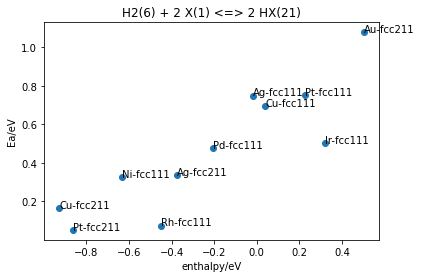

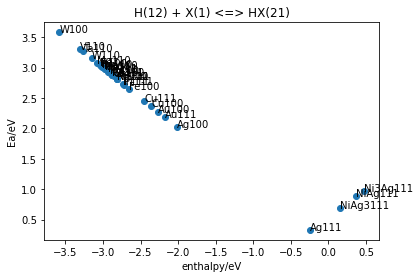

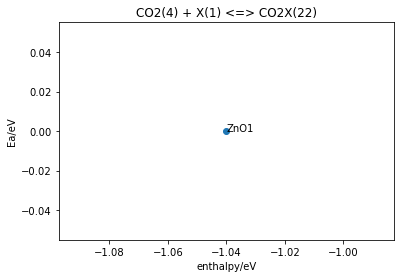

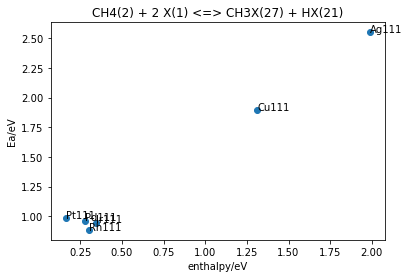

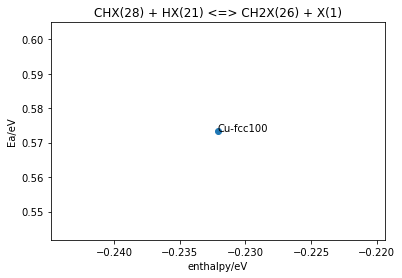

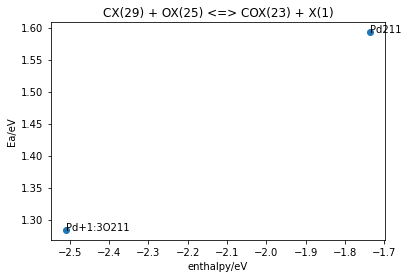

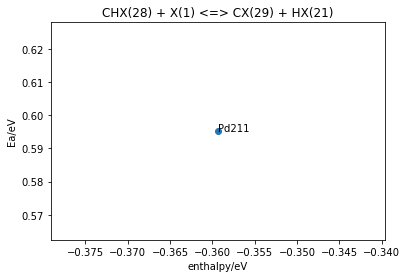

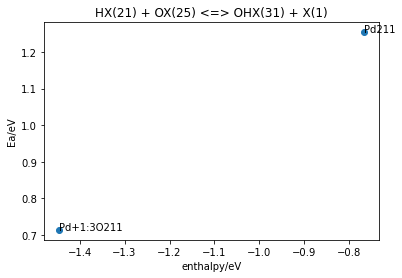

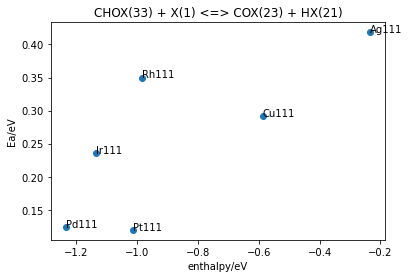

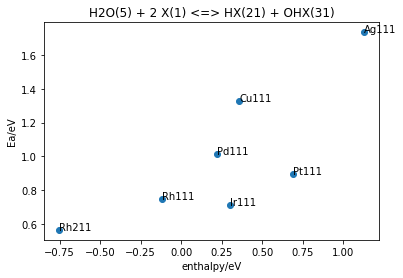

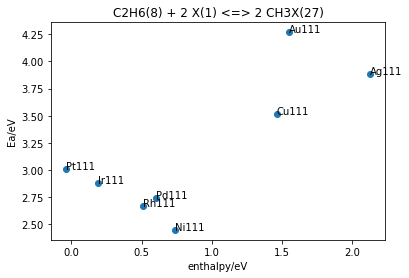

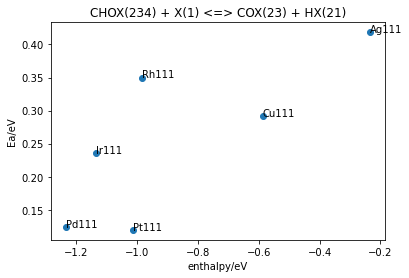

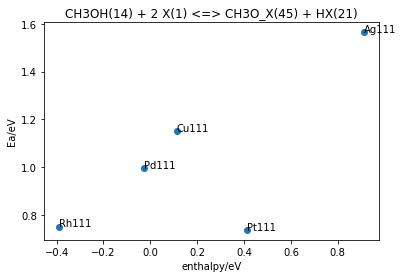

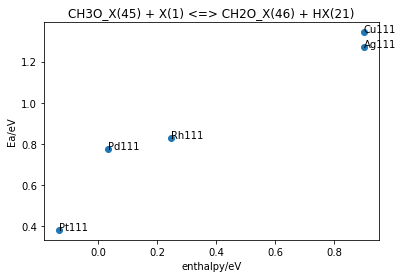

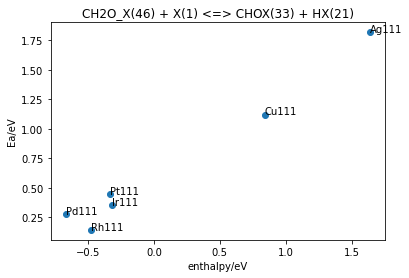

In [8]:
for i, v in rxn_list.items():
    df =pd.DataFrame(v)
    fig, ax = plt.subplots()
    plt.scatter(df.iloc[0,:], df.iloc[1,:])
    metals = df.columns
    for a, txt in enumerate(metals):
        plt.annotate(txt, (df.iloc[0,:][a], df.iloc[1,:][a]))
    plt.xlabel('enthalpy/eV')
    plt.ylabel('Ea/eV')
    plt.title(surf.reaction(i).equation)
    plt.show()

In [8]:
def get_Ea_from_E0_dH(E0, dHrxn, w0=1e9):
        """
        Return the activation energy in J/kmol corresponding to the given
        E0, enthalpy of reaction `dHrxn`, and w0, all in J/kmol.
        """
        E0 = float(E0)
        w0 = max(w0, 2*E0)
        assert w0 >= 2*E0, f"seems to work best when w0 > 2*Eo = {2*E0/1e6:.1f} kJ/mol, but w0={w0/1e6:.1f} kJ/mol"
        
        if E0 == dHrxn == 0:
            return 0
        if dHrxn < -4 * E0:
            return 0.0
        elif dHrxn > 4 * E0:
            return dHrxn
        else:
            Vp = 2 * w0 * (2 * w0 + 2 * E0) / (2 * w0 - 2 * E0)
            return (w0 + dHrxn / 2.0) * (Vp - 2 * w0 + dHrxn) ** 2 / (Vp ** 2 - (2 * w0) ** 2 + dHrxn ** 2)

def get_E0_from_Ea_dH(i, Ea, dHrxn, w0=1e9, plot=False, additional_point=None):
    """
    Return the E0 in J/kmol corresponding to the given Ea and dHrxn and w0 in J/kmol.
    """
    if Ea <= dHrxn:
        E0 = 0
        print(f"Assuming E0=0 because barrier Ea={Ea/1e6:.1f} < dHrxn={dHrxn/1e6:.1f} kJ/mol")
    else:
        def f(E0):
            return Ea - get_Ea_from_E0_dH(E0, dHrxn, w0=w0)
        E0_guess = Ea*.5 if dHrxn>0 else max(Ea*8,30e6)
        E0 = scipy.optimize.fsolve(f, E0_guess)[0]
            #print(f"E0 = {E0}")

        if plot:
            plt.ioff()
            plt.clf()
            dHs = np.linspace(min(-5*E0,dHrxn),max(5*E0,dHrxn))
            Eas = np.vectorize(lambda dH: get_Ea_from_E0_dH(E0, dH, w0=w0))(dHs)
            plt.plot(dHs/1e6, Eas/1e6)
            plt.plot(dHrxn/1e6, Ea/1e6, 'ro')
            plt.plot(0,E0/1e6,'bx')
            plt.text(0,E0/1e6,f'$E_0={E0/1e6:.1f}$ kJ/mol')
            plt.title('reaction {}'.format(i))
            plt.xlabel('$\Delta H_{rxn}$ (kJ/mol)')
            plt.ylabel('$E_a$ (kJ/mol)')
            if additional_point != None:
                for i, v in additional_point.items():
                    rgb = (random.random(), random.random(), random.random())
                    plt.scatter(v[0]*96.4869, v[1]*96.4869, c=[rgb])
                    plt.text(v[0]*96.4869,v[1]*96.4869, f'{i}')
                plt.show()
            else:
                plt.show()

        if not np.isclose(Ea, get_Ea_from_E0_dH(E0, dHrxn), rtol=0.002):
            print(f"Warning: {Ea} not close to {get_Ea_from_E0_dH(E0, dHrxn)}")

        return E0

52473714.96013821 J/kmol
BM RMSE 0.1590911648933874
slope: [0.59311385] intercept: 58014023.36191116
BEP RMSE: 0.147014877769076


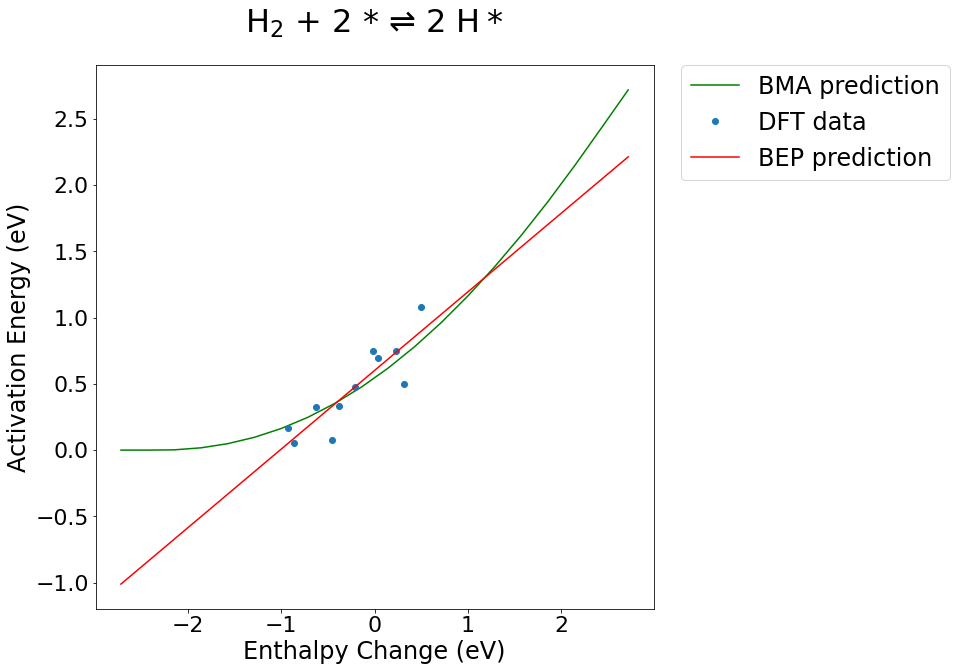

356838059.1355896 J/kmol
BM RMSE 1.2159534900627993
slope: [-0.71417605] intercept: 78910090.00254437
BEP RMSE: 0.17819700407032382


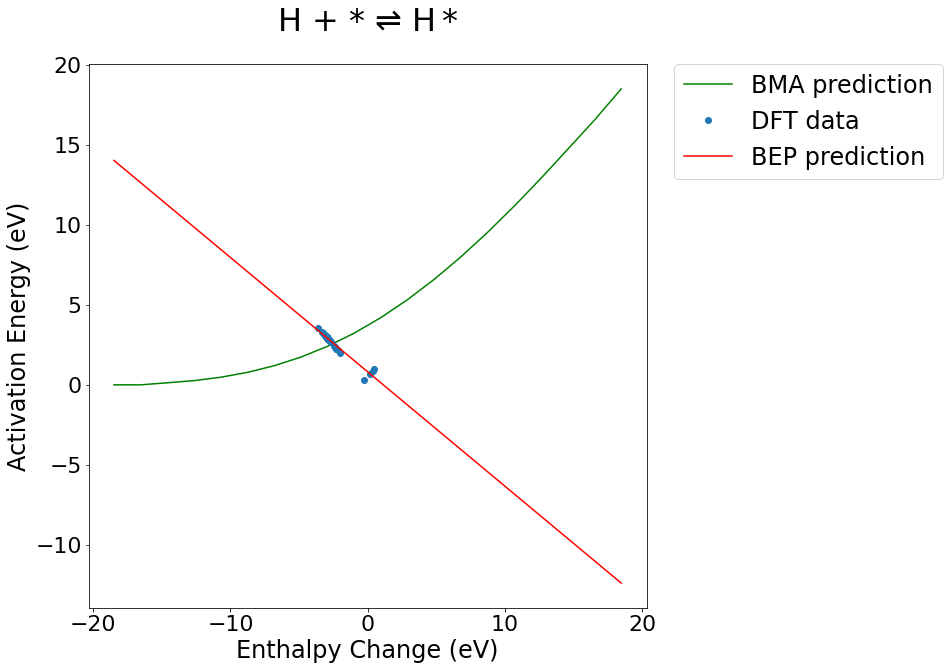

25051962.26275437 J/kmol
BM RMSE 0.0
slope: [0.] intercept: 0.0
BEP RMSE: 0.0


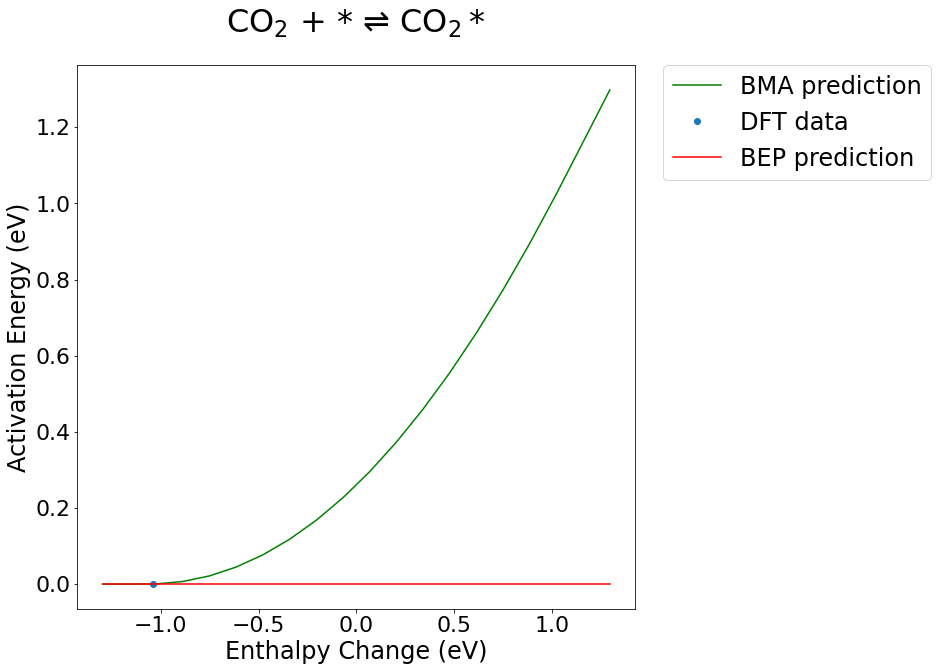

91622056.68337584 J/kmol
BM RMSE 0.1989743585243119
slope: [0.92034598] intercept: 67280022.74302554
BEP RMSE: 0.073622099665754


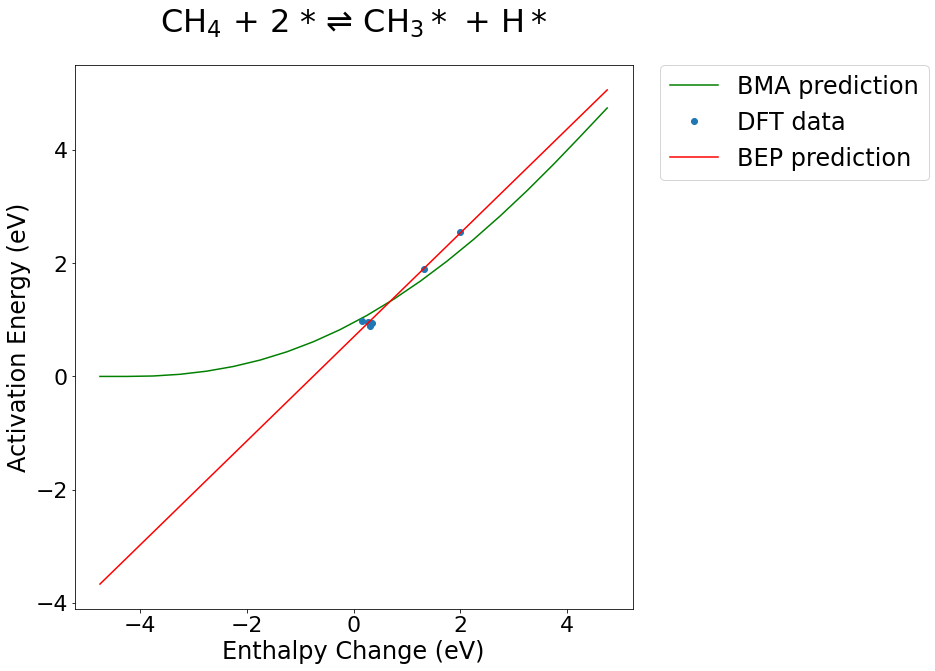

66013826.35976689 J/kmol
BM RMSE 9.992007221626409e-16
slope: [0.] intercept: 55320404.54680108
BEP RMSE: 0.0


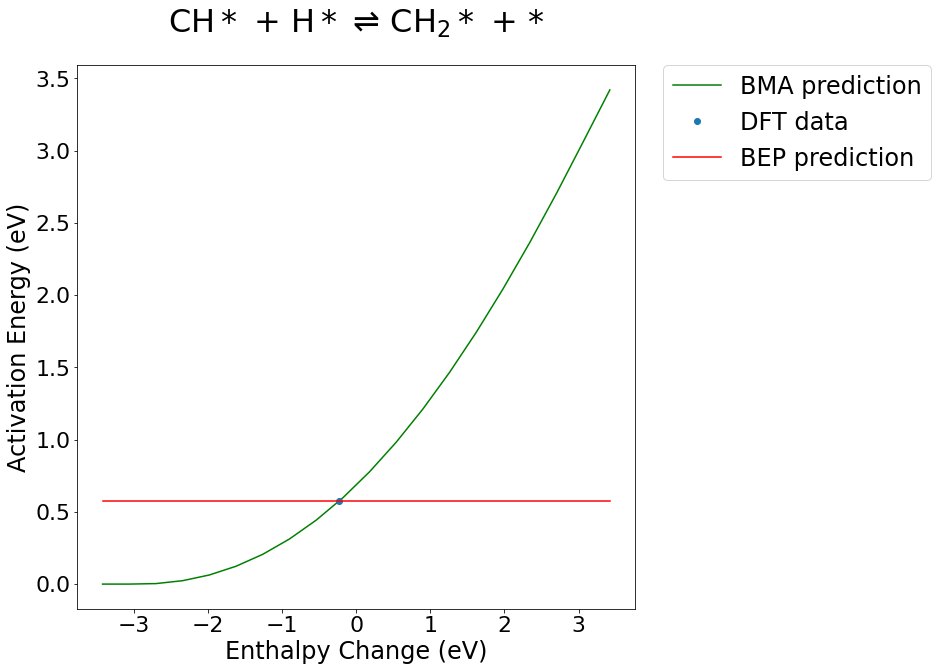

227411155.68531322 J/kmol
BM RMSE 0.011041927339642212
slope: [0.39933398] intercept: 220570318.1669929
BEP RMSE: 2.220446049250313e-16


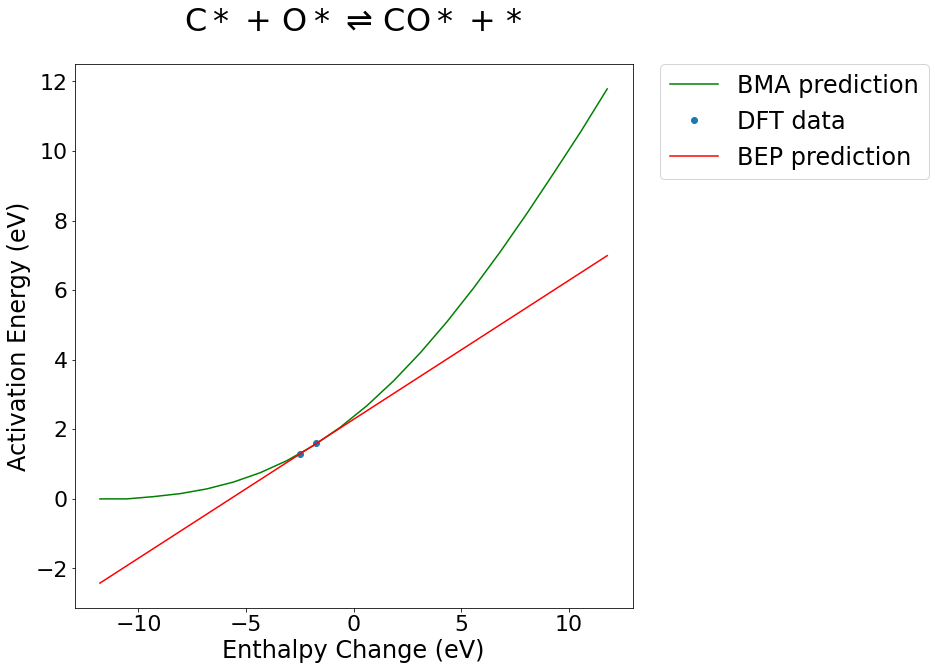

73679175.18045446 J/kmol
BM RMSE 2.220446049250313e-16
slope: [0.] intercept: 57431077.00503118
BEP RMSE: 0.0


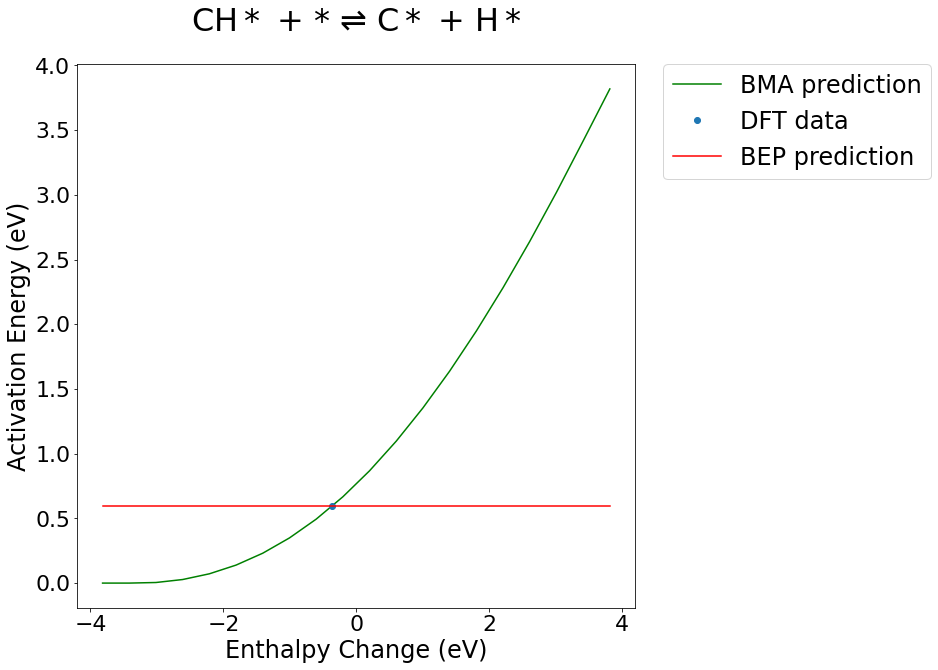

141852390.80201367 J/kmol
BM RMSE 0.13604349929446094
slope: [0.79733272] intercept: 180056032.18563277
BEP RMSE: 0.0


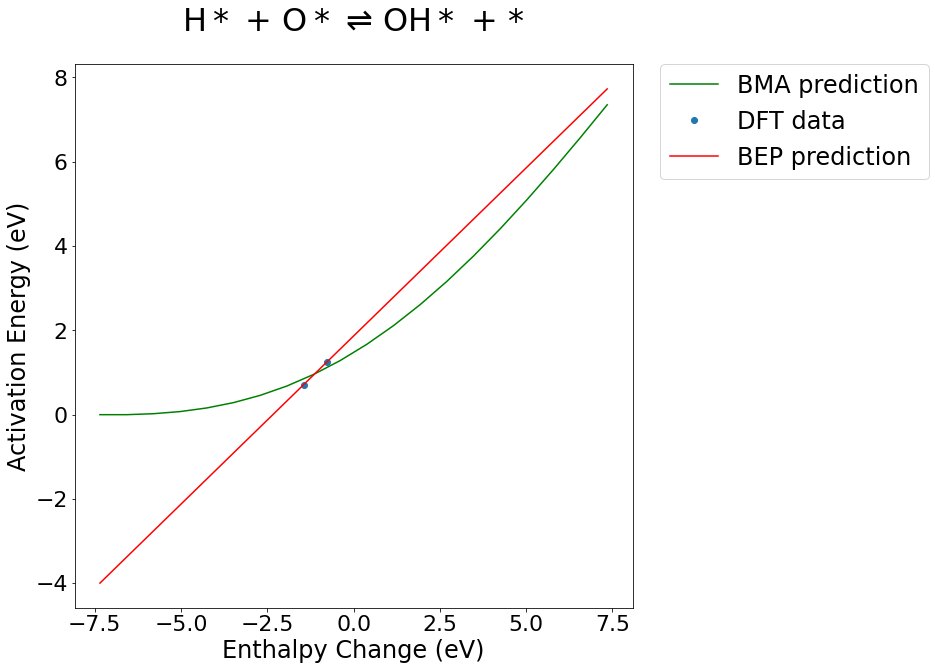

57354201.34479911 J/kmol
BM RMSE 0.07943906055122303
slope: [0.24407344] intercept: 45117630.08220685
BEP RMSE: 0.07078817224439513


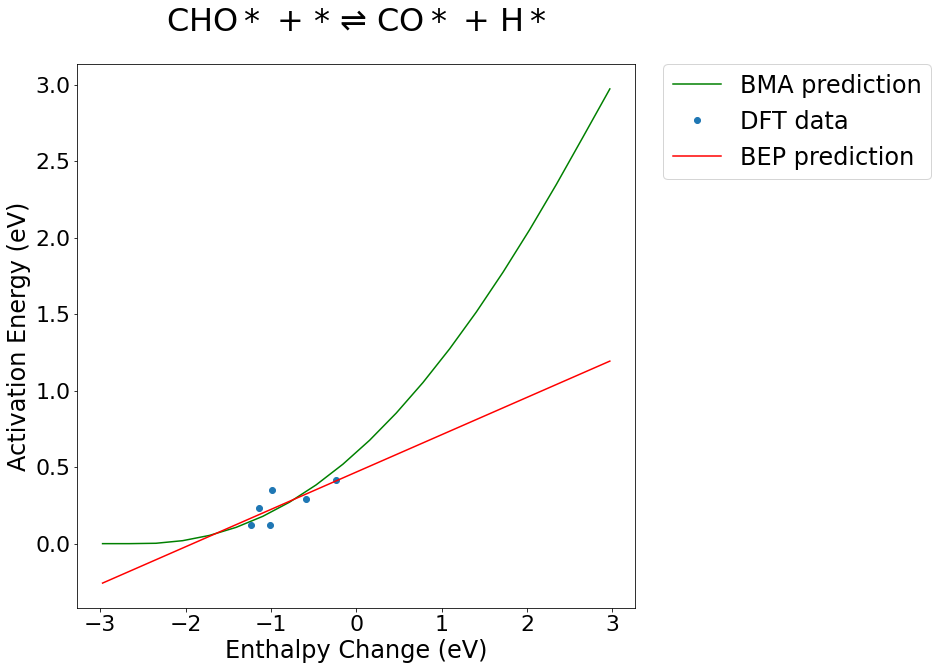

80994872.69763741 J/kmol
BM RMSE 0.2192687695166309
slope: [0.54328599] intercept: 82761105.2329794
BEP RMSE: 0.22981224450912877


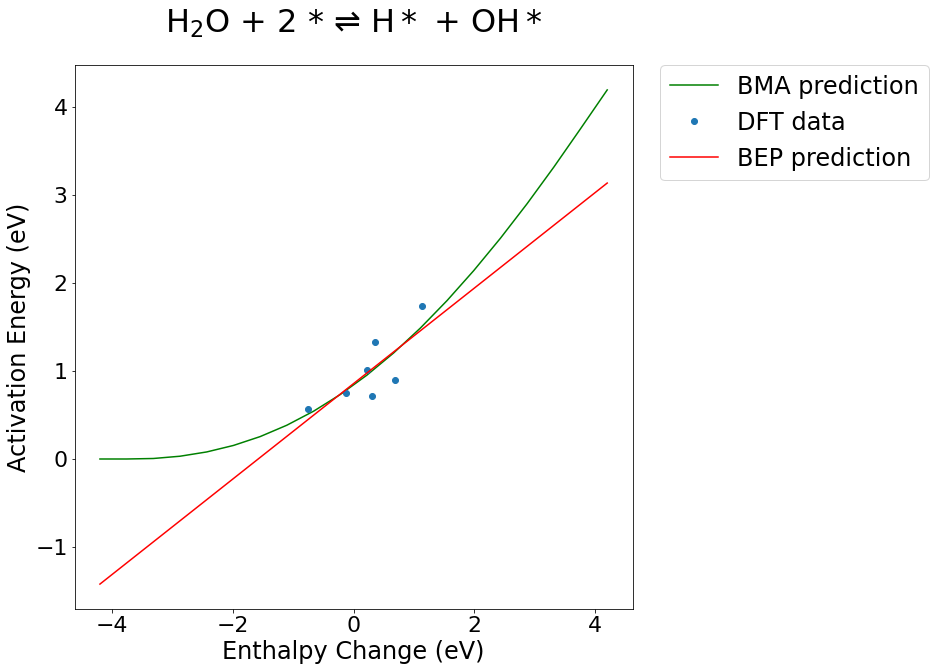

260014887.09579828 J/kmol
BM RMSE 0.3892449147951715
slope: [0.66493032] intercept: 249061109.60452652
BEP RMSE: 0.3860918977631976


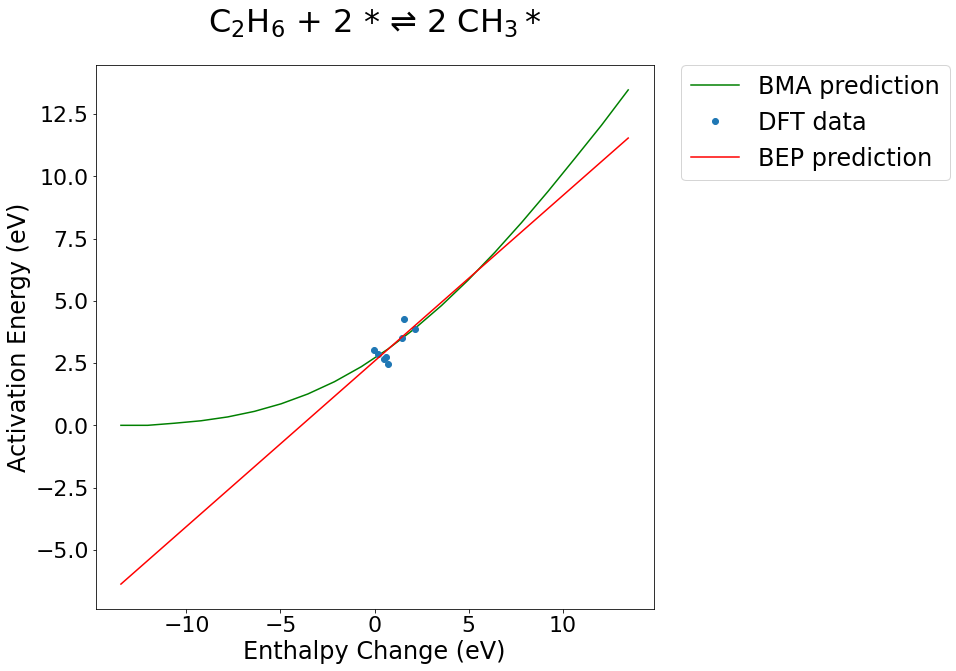

57354201.34479911 J/kmol
BM RMSE 0.07943906055122303
slope: [0.24407344] intercept: 45117630.08220685
BEP RMSE: 0.07078817224439513


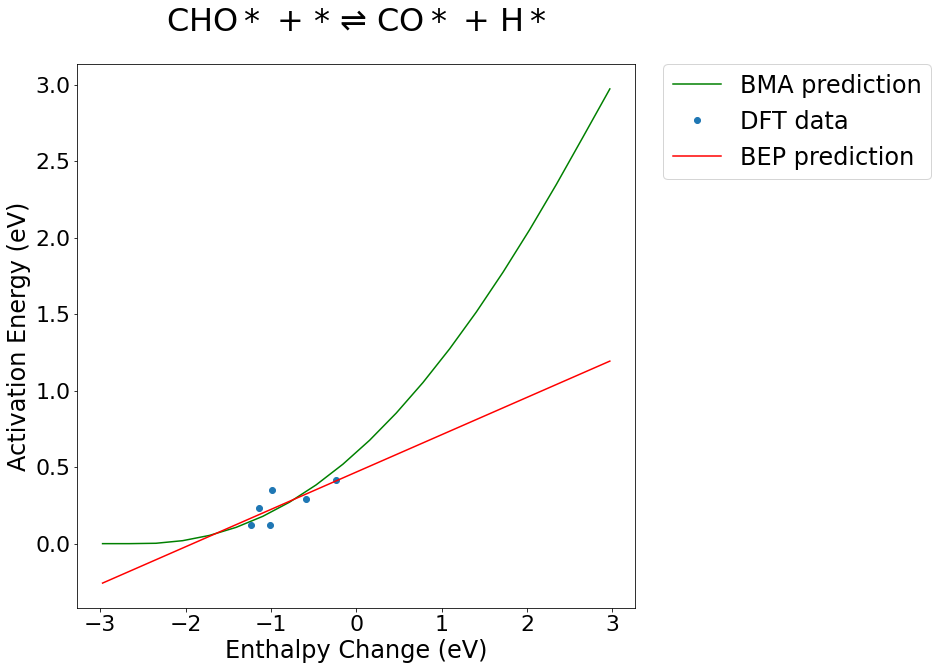

88852600.08934104 J/kmol
BM RMSE 0.20759031015828372
slope: [0.5001237] intercept: 90526481.00740035
BEP RMSE: 0.21163192359390023


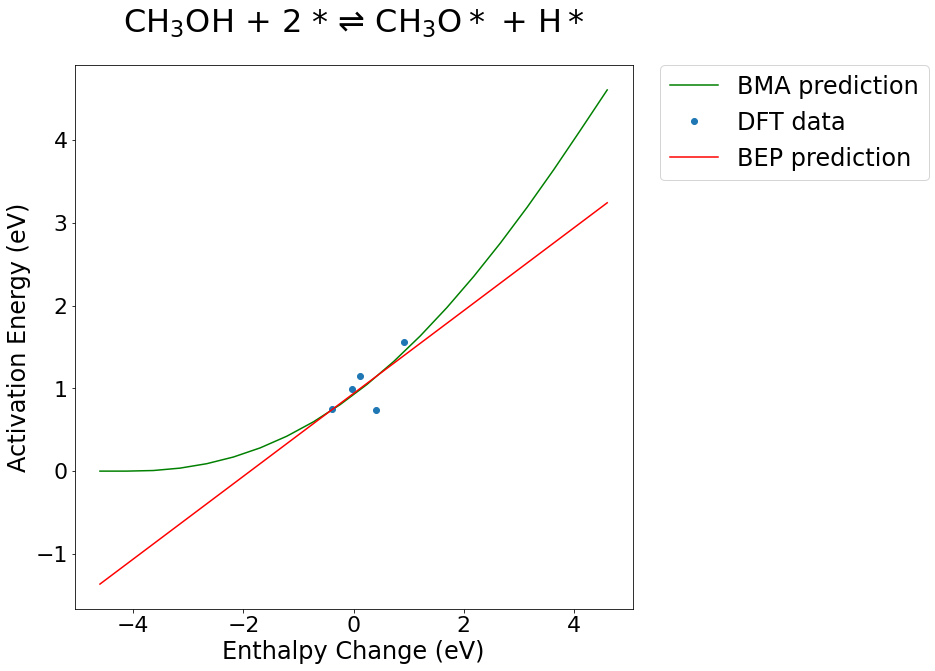

67098321.233405665 J/kmol
BM RMSE 0.12907588372265516
slope: [0.78827468] intercept: 59071344.82177921
BEP RMSE: 0.08714652292680065


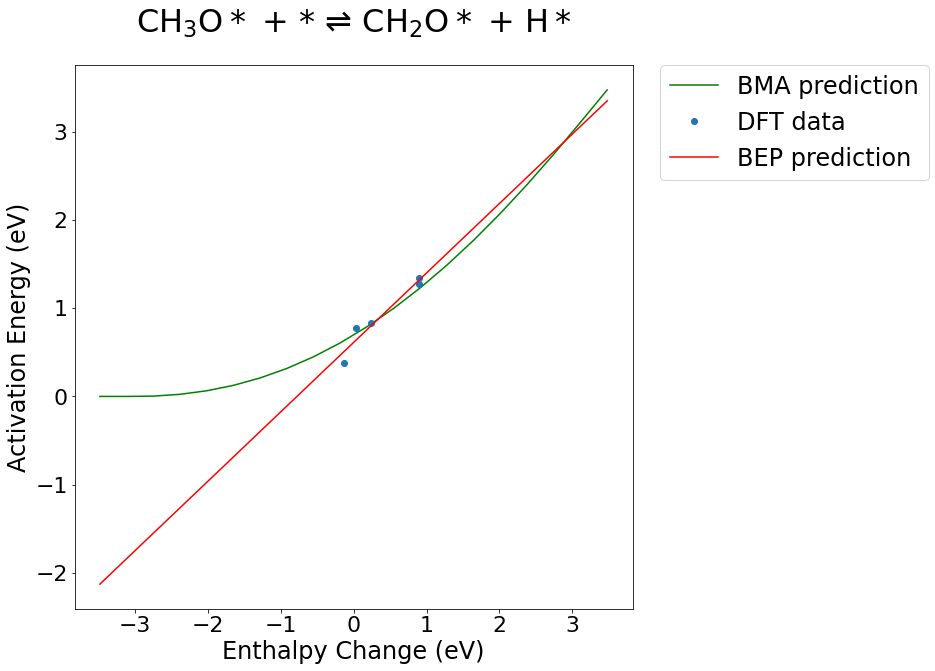

54587579.40640563 J/kmol
BM RMSE 0.10662981932908182
slope: [0.69691718] intercept: 59276970.48785214
BEP RMSE: 0.09293389747743322


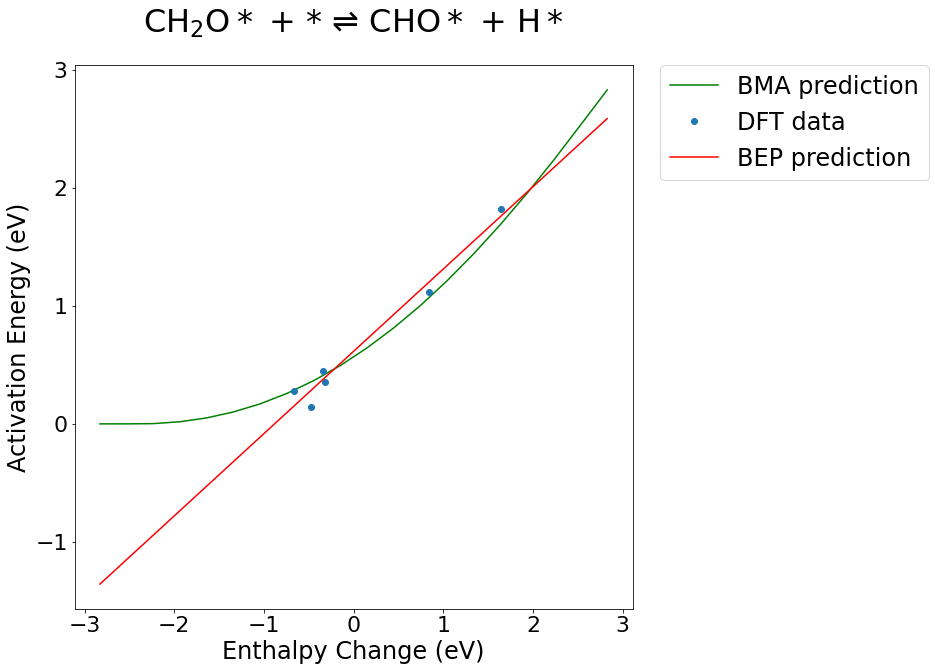

In [22]:
for i, v in rxn_list.items():
    intrinsic_Es = []
    for x, y in v.items():
        intrinsic_E = get_E0_from_Ea_dH(i, y[1]*96.4869e6, y[0]*96.4869e6, additional_point=v)
        intrinsic_Es.append(intrinsic_E)
#     intrinsic_Es = np.array(intrinsic_Es)
#     print(intrinsic_Es)
    E_0 = sum(intrinsic_Es) / len(intrinsic_Es)
#     E_0 = statistics.median(intrinsic_Es)
    print(E_0, "J/kmol")
    predicted_Es = []
    energies = []
    enthalpies = []
    predict_Es = []
    for x, y in v.items():
        energies.append(y[1]*96.4869e6)
        enthalpies.append(y[0]*96.4869e6)
        predict_Es.append(get_Ea_from_E0_dH(E_0, y[0]*96.4869e6))
        
    for j in np.linspace(-5*E_0, 5*E_0, 20):
        predicted_Es.append(get_Ea_from_E0_dH(E_0, j))
        
    bm_rmse = sqrt(mean_squared_error(np.array(energies) / 96.4869e6, np.array(predict_Es) / 96.4869e6))
    print("BM RMSE", bm_rmse)
    
    
    plt.figure()
#     plt.rcParams.update({'font.size': 18})
#     plt.rcParams['axes.titley'] = 1.0    # y is in axes-relative coordinates.
#     plt.rcParams['axes.titlepad'] = 18 
    plt.rcParams.update({'font.size': 22})
    plt.rcParams["figure.figsize"] = (10,10)
    plt.plot(np.linspace(-5*E_0, 5*E_0, 20) / 96.4869e6, np.array(predicted_Es) / 96.4869e6, '-g', label='BMA prediction')
    plt.plot(np.array(enthalpies) / 96.4869e6, np.array(energies) / 96.4869e6,'o', label='DFT data')
    np.array(enthalpies).reshape((-1, 1))
    reg = LinearRegression().fit(np.array(enthalpies).reshape((-1, 1)), np.array(energies))
    print('slope:', reg.coef_, 'intercept:', reg.intercept_)
    bep_energies = reg.coef_ * np.linspace(-5*E_0, 5*E_0, 20) + reg.intercept_
    plt.plot(np.linspace(-5*E_0, 5*E_0, 20) / 96.4869e6, np.array(bep_energies) / 96.4869e6, '-r', label='BEP prediction')
    BEP_RMSE = sqrt(mean_squared_error(np.array(energies) / 96.4869e6, (reg.coef_ * np.array(enthalpies) + reg.intercept_) / 96.4869e6))
    print('BEP RMSE:', BEP_RMSE)
    plt.title(eliminate_index(surf.reactions())[i], fontdict={'fontsize': 32}, y=1.05)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=24)
    plt.xlabel("Enthalpy Change (eV)", fontdict={'fontsize': 24})
    plt.ylabel("Activation Energy (eV)", fontdict={'fontsize': 24})
    plt.savefig(f'cat_hub_plots/rxn{i}.pdf', bbox_inches='tight')
    plt.show()

55529485.99542843 J/kmol
BM RMSE 0.16016770746997866
slope: [0.59311385] intercept: 58014023.36191116
BEP RMSE: 0.147014877769076


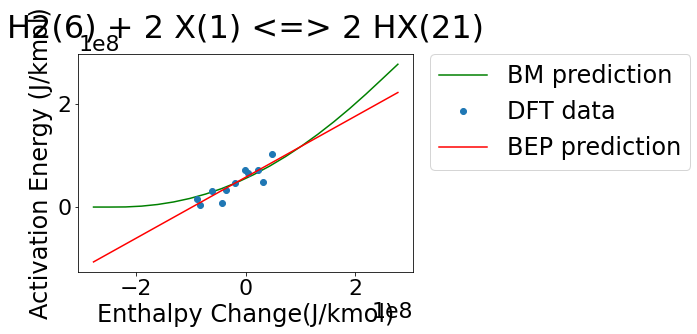

342560468.1424727 J/kmol
BM RMSE 1.2197340579559914
slope: [-0.71417605] intercept: 78910090.00254437
BEP RMSE: 0.17819700407032382


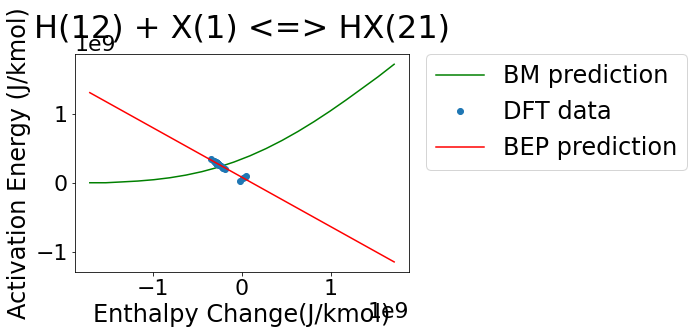

25051962.26275437 J/kmol
BM RMSE 0.0
slope: [0.] intercept: 0.0
BEP RMSE: 0.0


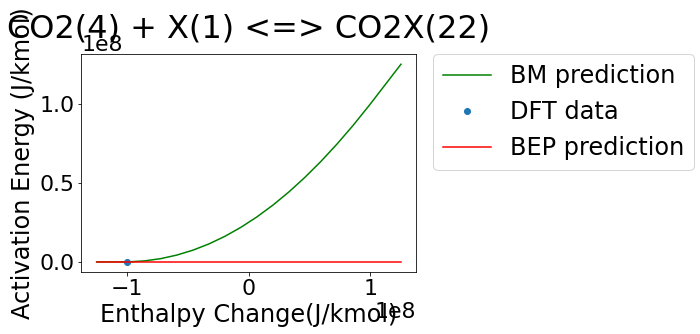

87062790.62695558 J/kmol
BM RMSE 0.19603943082085656
slope: [0.92034598] intercept: 67280022.74302556
BEP RMSE: 0.07362209966575395


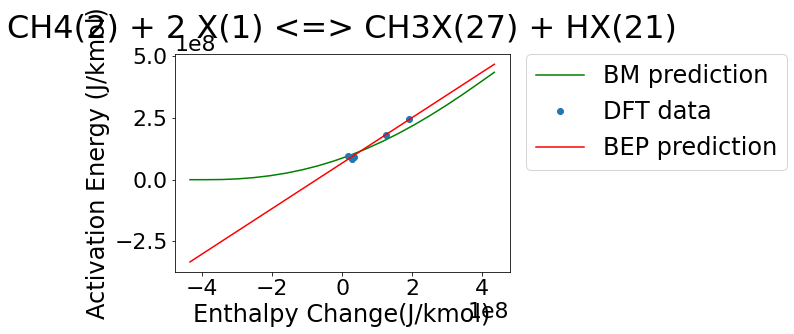

66013826.35976689 J/kmol
BM RMSE 9.992007221626409e-16
slope: [0.] intercept: 55320404.54680108
BEP RMSE: 0.0


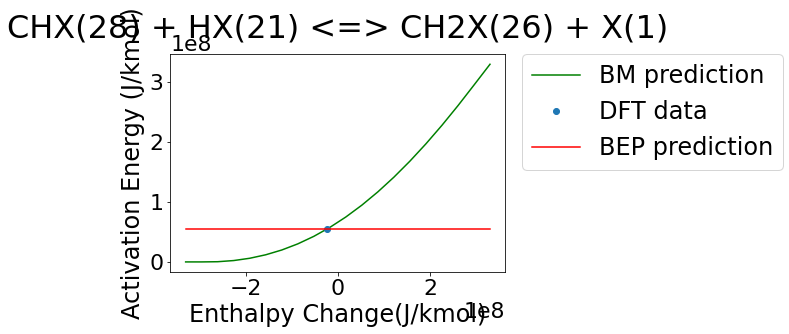

228538574.58114356 J/kmol
BM RMSE 0.015297861567119157
slope: [0.39933398] intercept: 220570318.1669929
BEP RMSE: 2.220446049250313e-16


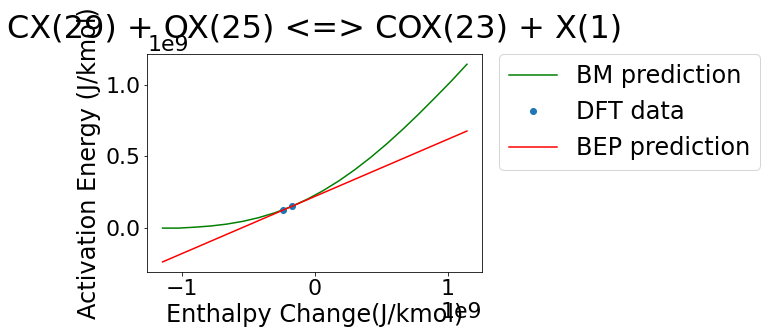

73679175.18045446 J/kmol
BM RMSE 2.220446049250313e-16
slope: [0.] intercept: 57431077.00503118
BEP RMSE: 0.0


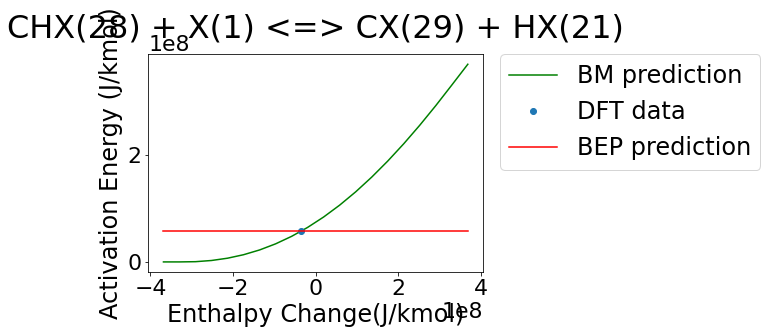

155543523.82462096 J/kmol
BM RMSE 0.18832418295082592
slope: [0.79733272] intercept: 180056032.18563277
BEP RMSE: 0.0


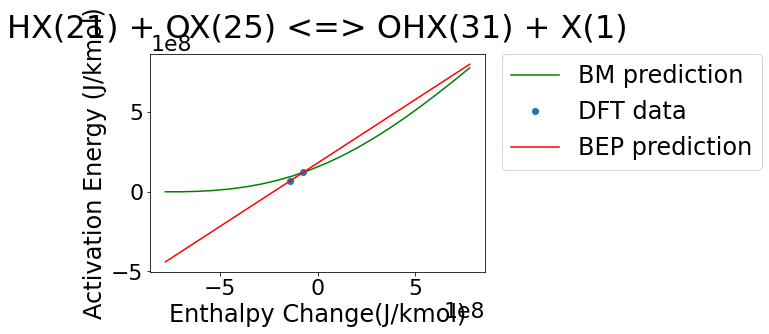

54707897.36472626 J/kmol
BM RMSE 0.08162123092233817
slope: [0.24407344] intercept: 45117630.08220685
BEP RMSE: 0.07078817224439513


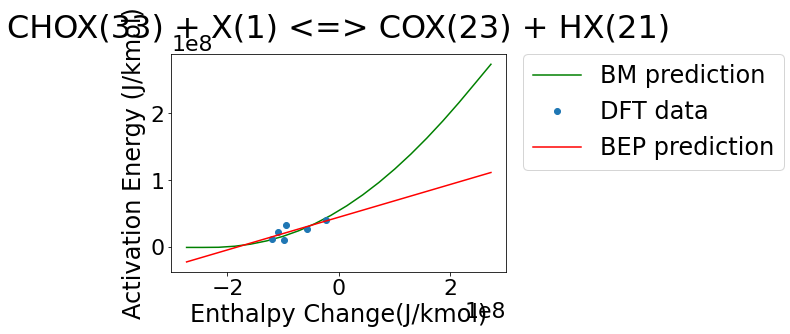

77777524.82637064 J/kmol
BM RMSE 0.22128991467634598
slope: [0.54328599] intercept: 82761105.2329794
BEP RMSE: 0.22981224450912877


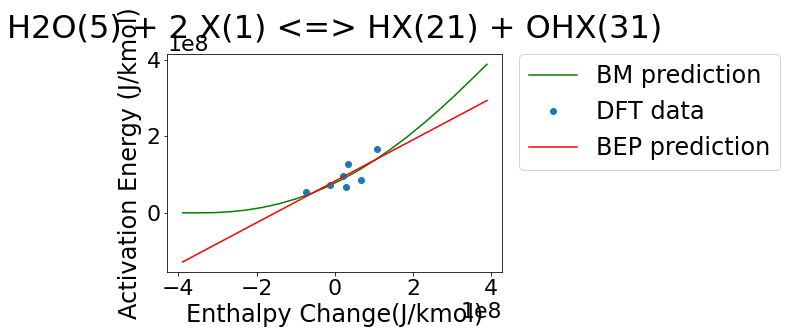

260563995.05704322 J/kmol
BM RMSE 0.3893239091192052
slope: [0.66493032] intercept: 249061109.60452652
BEP RMSE: 0.3860918977631976


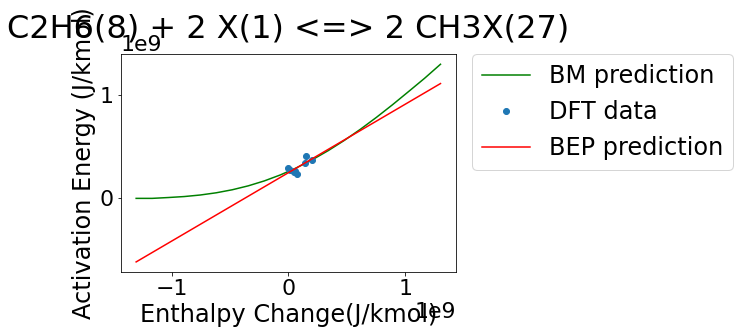

54707897.36472626 J/kmol
BM RMSE 0.08162123092233817
slope: [0.24407344] intercept: 45117630.08220685
BEP RMSE: 0.07078817224439513


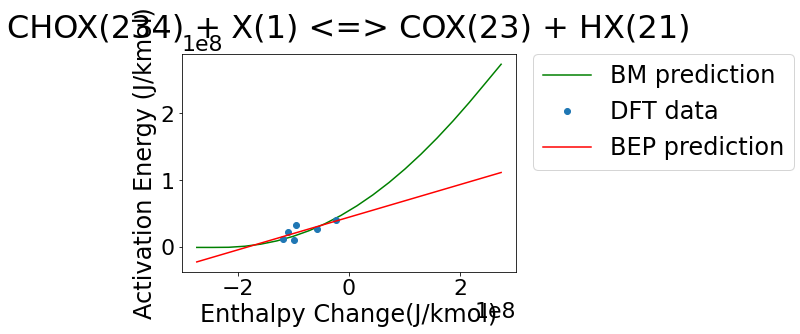

90206281.07602833 J/kmol
BM RMSE 0.20806340418373906
slope: [0.5001237] intercept: 90526481.00740035
BEP RMSE: 0.21163192359390023


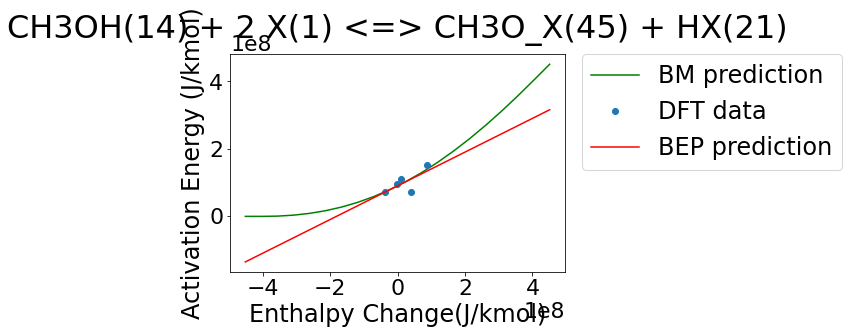

67529721.26774406 J/kmol
BM RMSE 0.129374278198547
slope: [0.78827468] intercept: 59071344.82177922
BEP RMSE: 0.08714652292680067


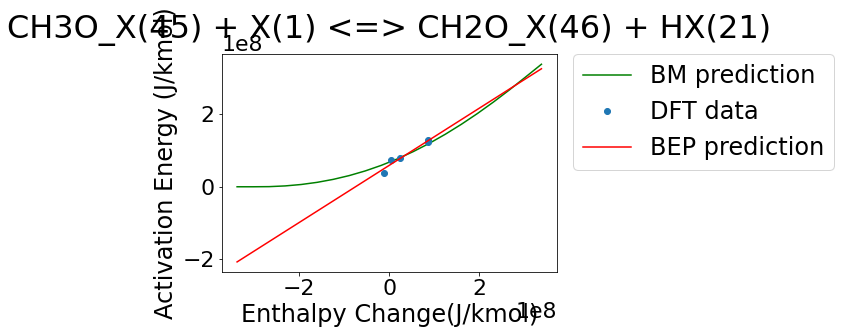

54103267.77600901 J/kmol
BM RMSE 0.10573445264251316
slope: [0.69691718] intercept: 59276970.48785214
BEP RMSE: 0.09293389747743322


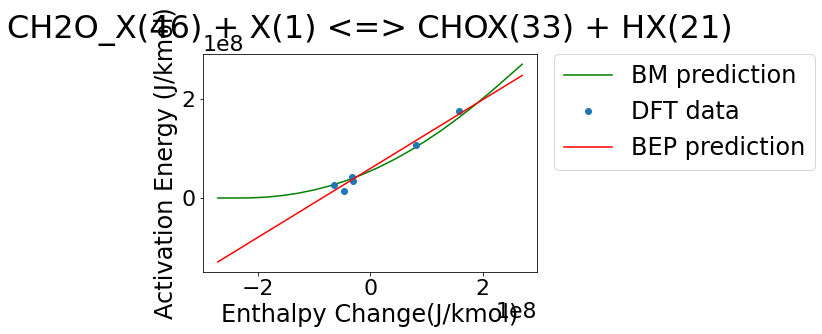

In [11]:
for i, v in rxn_list.items():
    intrinsic_Es = []
    energies = []
    enthalpies = []
    for x, y in v.items():
        intrinsic_E = get_E0_from_Ea_dH(i, y[1]*96.4869e6, y[0]*96.4869e6, additional_point=v)
        intrinsic_Es.append(intrinsic_E)
        energies.append(y[1]*96.4869e6)
        enthalpies.append(y[0]*96.4869e6)

#     intrinsic_Es = np.array(intrinsic_Es)
#     E_0 = sum(intrinsic_Es) / len(intrinsic_Es)
    
    rmses = []
    for E in intrinsic_Es:
        predicted_Es = []
        for h in enthalpies:
            predicted_Es.append(get_Ea_from_E0_dH(E,h))
        rmse = sqrt(mean_squared_error(np.array(energies) / 96.4869e6, np.array(predicted_Es) / 96.4869e6)) 
        rmses.append(rmse)
    E_0 = intrinsic_Es[rmses.index(min(rmses))]
    
    print(E_0, "J/kmol")
    print("BM RMSE", min(rmses))
    
    predicted_Es = []
    for j in np.linspace(-5*E_0, 5*E_0, 20):
        predicted_Es.append(get_Ea_from_E0_dH(E_0, j))
    plt.rcParams.update({'font.size': 22})
    plt.figure()
    plt.plot(np.linspace(-5*E_0, 5*E_0, 20), predicted_Es, '-g', label='BM prediction')
    plt.plot(enthalpies, energies,'o', label='DFT data')
    np.array(enthalpies).reshape((-1, 1))
    reg = LinearRegression().fit(np.array(enthalpies).reshape((-1, 1)), np.array(energies))
    print('slope:', reg.coef_, 'intercept:', reg.intercept_)
    bep_energies = reg.coef_ * np.linspace(-5*E_0, 5*E_0, 20) + reg.intercept_
    BEP_RMSE = sqrt(mean_squared_error(np.array(energies) / 96.4869e6, (reg.coef_ * np.array(enthalpies) + reg.intercept_) / 96.4869e6))
    print('BEP RMSE:', BEP_RMSE)
    plt.plot(np.linspace(-5*E_0, 5*E_0, 20), bep_energies, '-r', label='BEP prediction')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=24)
    plt.title(f'{surf.reaction(i).equation}', fontdict={'fontsize': 32}, y=1.05)
    plt.xlabel("Enthalpy Change(J/kmol)", fontdict={'fontsize': 24})
    plt.ylabel("Activation Energy (J/kmol)", fontdict={'fontsize': 24})
#     plt.title(surf.reaction(i))
#     plt.legend()
    plt.show()

## Add in specific w0, see the changes

<ol>
     <li>H2(6) + 2 X(1) <=> 2 HX(21)</li>
     <li>CH4(2) + 2 X(1) <=> CH3X(27) + HX(21)</li>
     <li>CX(29) + OX(25) <=> COX(23) + X(1)</li>
     <li>HX(21) + OX(25) <=> OHX(31) + X(1)</li>
     <li>CHOX(33) + X(1) <=> COX(23) + HX(21)</li>
     <li>H2O(5) + 2 X(1) <=> HX(21) + OHX(31)</li>
     <li>C2H6(8) + 2 X(1) <=> 2 CH3X(27)</li>
     <li>CHOX(234) + X(1) <=> COX(23) + HX(21)</li>
     <li>CH3OH(14) + 2 X(1) <=> CH3O_X(45) + HX(21)</li>
     <li>CH3O_X(45) + X(1) <=> CH2O_X(46) + HX(21)</li>
     <li>CH2O_X(46) + X(1) <=> CHOX(33) + HX(21)</li>
</ol>

In [9]:
# reactions to look into
for i, v in rxn_list.items():
    if len(v) != 1:
        print(surf.reaction(i), v)

H2(6) + 2 X(1) <=> 2 HX(21) {'Cu-fcc211': [-0.9265589536807965, 0.1664545594030642], 'Cu-fcc111': [0.039544333070807625, 0.6925007694007945], 'Ir-fcc111': [0.31881913165852893, 0.502491014667612], 'Ag-fcc211': [-0.3767395851537003, 0.33489282878144877], 'Ag-fcc111': [-0.01655499849584885, 0.7485479911556467], 'Au-fcc211': [0.5017531099365442, 1.0774109130688885], 'Pt-fcc211': [-0.8607067896009539, 0.05143441579275532], 'Pt-fcc111': [0.22493624772323528, 0.7493218829440593], 'Rh-fcc111': [-0.4512464663130231, 0.07428306751535274], 'Ni-fcc111': [-0.6327049752653693, 0.32444324874086305], 'Pd-fcc111': [-0.20532323377483408, 0.4776672925981984]}
H(12) + X(1) <=> HX(21) {'NiAg3111': [0.153551397, 0.688196257], 'NiAg111': [0.369693265, 0.882723939], 'Cu100': [-2.36, 2.36], 'Ni111': [-2.94, 2.94], 'Ni3Ag111': [0.470604782, 0.973544304], 'Ag100': [-2.02, 2.02], 'Cu111': [-2.45, 2.45], 'Os1': [-2.86, 2.86], 'V110': [-3.31, 3.31], 'Pt100': [-2.91, 2.91], 'Fe100': [-2.65, 2.65], 'Re1': [-3.04, 3.

### Add HX bond energy for H2 + 2X <=> 2HX

In [10]:
mdb= MetalDatabase()
mdb.load('/home/xu.chao/RMG-database/input/surface')
metals_in_db = ['Pt111', 'Ru0001', 'Rh111', 'Ir111', 'Au111', 'Pd111', 'Cu111', 'Ag111', 'Ni111', 'Co0001',
                'Pt211', 'Rh211', 'Ag211', 'Pd211', 'Au211', 'Ir211', 'Ru211', 'Co211', 'Ni211', 
                'Cu211']

52336435.386850834 J/kmol


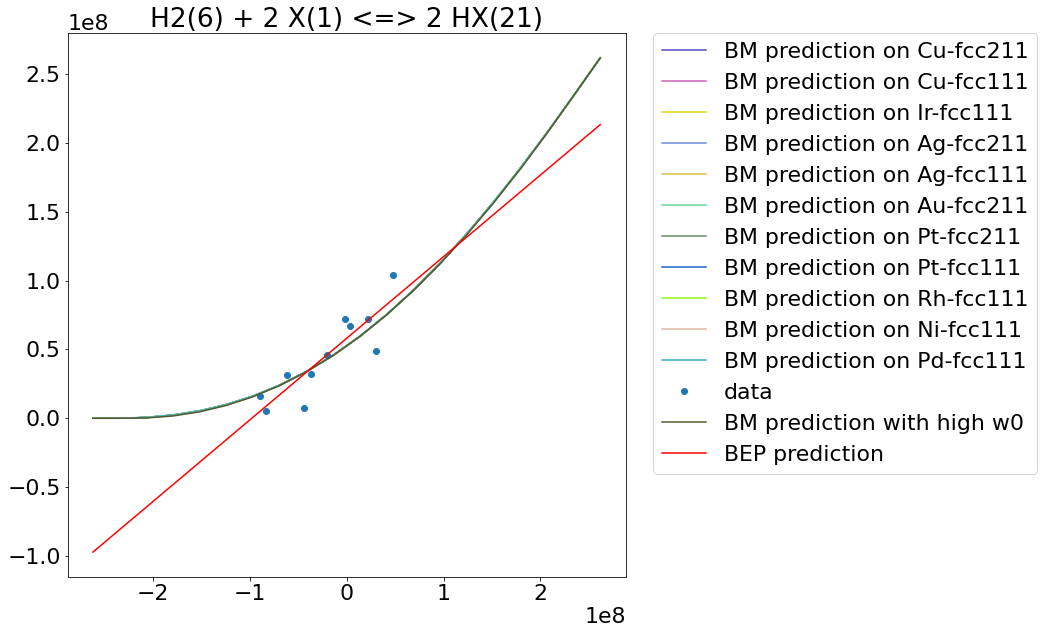

In [13]:
w0s = {}
metals = list(rxn_list[list(rxn_list.keys())[0]].keys())
ms = [m.replace('-fcc', '') for m in metals]
plt.rcParams["figure.figsize"] = (10,10)
for i in range(len(ms)):
    w0s[metals[i]] = (abs(mdb.get_binding_energies(ms[i])['H'].value) * 2 + 4.477) * 96.4869 * 1e6 / 2# in J/kmol

i = 0
v = rxn_list[0]
intrinsic_Es = []
for x, y in v.items():
    intrinsic_E = get_E0_from_Ea_dH(i, y[1]*96.4869e6, y[0]*96.4869e6, w0s[x], additional_point=v)
    intrinsic_Es.append(intrinsic_E)
#     intrinsic_Es = np.array(intrinsic_Es)
E_0 = sum(intrinsic_Es) / len(intrinsic_Es)
#     E_0 = statistics.median(intrinsic_Es)
print(E_0, "J/kmol")
energies = []
enthalpies = []
predict_Es = []
for x, y in v.items():
    energies.append(y[1]*96.4869e6)
    enthalpies.append(y[0]*96.4869e6)
    predict_Es.append(get_Ea_from_E0_dH(E_0, y[0]*96.4869e6, w0s[x]))

for x, y in v.items():
    predicted_Es = []
    for j in np.linspace(-5*E_0, 5*E_0, 20):
        predicted_Es.append(get_Ea_from_E0_dH(E_0, j, w0s[x]))
        
    r = random.random()
    b = random.random()
    g = random.random()
    color = (r, g, b)   
    plt.plot(np.linspace(-5*E_0, 5*E_0, 20), predicted_Es, c=color, label= f'BM prediction on {x}')
plt.plot(enthalpies, energies,'o', label='data')


predicted_Es = []
for j in np.linspace(-5*E_0, 5*E_0, 20):
    predicted_Es.append(get_Ea_from_E0_dH(E_0, j))
r = random.random()
b = random.random()
g = random.random()
color = (r, g, b)
plt.plot(np.linspace(-5*E_0, 5*E_0, 20), predicted_Es, c=color, label= f'BM prediction with high w0')
np.array(enthalpies).reshape((-1, 1))
reg = LinearRegression().fit(np.array(enthalpies).reshape((-1, 1)), np.array(energies))
# print('slope:', reg.coef_, 'intercept:', reg.intercept_)
bep_energies = reg.coef_ * np.linspace(-5*E_0, 5*E_0, 20) + reg.intercept_
plt.plot(np.linspace(-5*E_0, 5*E_0, 20), bep_energies, '-r', label='BEP prediction')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title(f'{surf.reaction(i).equation}')
plt.show()

# bm_rmse = sqrt(mean_squared_error(np.array(energies) / 96.4869e6, np.array(predict_Es) / 96.4869e6))
# print("BM RMSE", bm_rmse)



# BEP_RMSE = sqrt(mean_squared_error(np.array(energies) / 96.4869e6, (reg.coef_ * np.array(enthalpies) + reg.intercept_) / 96.4869e6))
# print('BEP RMSE:', BEP_RMSE)
# plt.xlabel("Enthalpy Change(J/kmol)")
# plt.ylabel("Activation Energy (J/kmol)")
# plt.title(surf.reaction(i))
# plt.legend()
# plt.show()

## Add w0 for CH4(2) + 2 X(1) <=> CH3X(27) + HX(21)

In [23]:
def bm_w0_spec_plot(rxns, key_, w0s):
    """
    This function plot Blowers Masel with specific w0s
    rxns: a dictionary with key as the reaction index in the model, and value as a list with enthalpy and activation energy
    key_: the key of rxns to plot
    w0s: this is the dictionary with the metal surface name as the keys and w0 as the values
    """
    i = key_
    v = rxns[key_]
    intrinsic_Es = []
    plt.rcParams.update({'font.size': 22})
    plt.rcParams["figure.figsize"] = (10,10)
    for x, y in v.items():
        intrinsic_E = get_E0_from_Ea_dH(i, y[1]*96.4869e6, y[0]*96.4869e6, w0s[x], additional_point=v)
        intrinsic_Es.append(intrinsic_E)
    #     intrinsic_Es = np.array(intrinsic_Es)
    E_0 = sum(intrinsic_Es) / len(intrinsic_Es)
    #     E_0 = statistics.median(intrinsic_Es)
    print(E_0, "J/kmol")
    energies = []
    enthalpies = []
    predict_Es = []
    for x, y in v.items():
        energies.append(y[1]*96.4869e6)
        enthalpies.append(y[0]*96.4869e6)
        predict_Es.append(get_Ea_from_E0_dH(E_0, y[0]*96.4869e6, w0s[x]))

    for x, y in v.items():
        predicted_Es = []
        for j in np.linspace(-5*E_0, 5*E_0, 20):
            predicted_Es.append(get_Ea_from_E0_dH(E_0, j, w0s[x]))

        r = random.random()
        b = random.random()
        g = random.random()
        color = (r, g, b)   
        plt.plot(np.linspace(-5*E_0, 5*E_0, 20) / 96.4869e6, np.array(predicted_Es) / 96.4869e6, c=color, label= f'$w_0$ on {x}')
    plt.plot(np.array(enthalpies) / 96.4869e6, np.array(energies) / 96.4869e6, 'o', label='DFT data')


    predicted_Es = []
    for j in np.linspace(-5*E_0, 5*E_0, 20):
        predicted_Es.append(get_Ea_from_E0_dH(E_0, j))
    r = random.random()
    b = random.random()
    g = random.random()
    color = (r, g, b)
    plt.plot(np.linspace(-5*E_0, 5*E_0, 20) / 96.4869e6, np.array(predicted_Es) / 96.4869e6, c=color, label= 'high $w_0$ (1000 kJ/mol)')
    
    predicted_Es = []
    for j in np.linspace(-5*E_0, 5*E_0, 20):
        predicted_Es.append(get_Ea_from_E0_dH(E_0, j, 10))
    r = random.random()
    b = random.random()
    g = random.random()
    color = (r, g, b)
    plt.plot(np.linspace(-5*E_0, 5*E_0, 20) / 96.4869e6, np.array(predicted_Es) / 96.4869e6, c=color, label= 'low $w_0$ (10$^{-5}$ kJ/mol)')
    np.array(enthalpies).reshape((-1, 1))
    reg = LinearRegression().fit(np.array(enthalpies).reshape((-1, 1)), np.array(energies))
    # print('slope:', reg.coef_, 'intercept:', reg.intercept_)
    bep_energies = reg.coef_ * np.linspace(-5*E_0, 5*E_0, 20) + reg.intercept_
#     plt.plot(np.linspace(-5*E_0, 5*E_0, 20) / 96.4869e6, np.array(bep_energies) / 96.4869e6, '-r', label='BEP prediction')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=24)
    plt.title(f'{eliminate_index([surf.reaction(i)])[0]}', fontdict={'fontsize': 32}, y=1.05)
    plt.xlabel("Enthalpy Change (eV)", fontdict={'fontsize': 24})
    plt.ylabel("Activation Energy (eV)", fontdict={'fontsize': 24})
    plt.savefig('cat_hub_plots/w0_comparison.pdf', bbox_inches='tight')
    plt.show()
    return 0

{'Pt111': 676799641.0979999, 'Rh111': 695422095.2325001, 'Ag111': 475746028.092, 'Cu111': 568991450.6865, 'Pd111': 691827958.2075001, 'Ir111': 684047737.026}
91327604.16766022 J/kmol


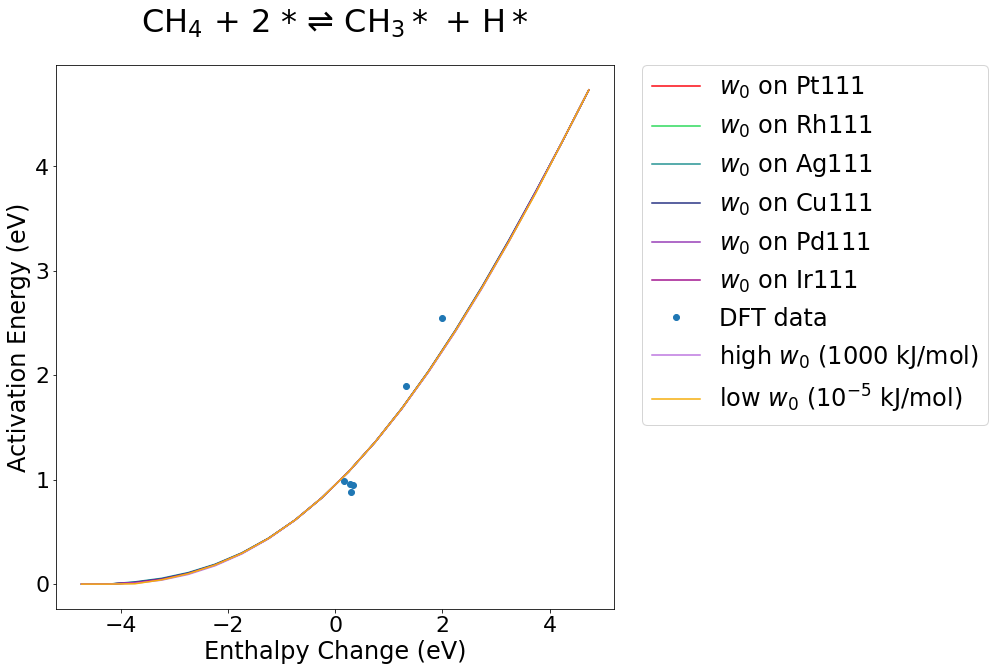

0

In [24]:
w0s = {}
metals = list(rxn_list[list(rxn_list.keys())[3]].keys()) # the value to be change should be the key index not the key
for i in range(len(metals)):
    w0s[metals[i]] = (abs(mdb.get_binding_energies(metals[i])['H'].value) + abs(mdb.get_binding_energies(metals[i])['C'].value) + 4.25) * 96.4869 * 1e6 / 2# in J/kmol
print(w0s)
bm_w0_spec_plot(rxn_list, list(rxn_list.keys())[3], w0s)

## Add w0 for CHOX(33) + X(1) <=> COX(23) + HX(21)

56633383.39304202 J/kmol


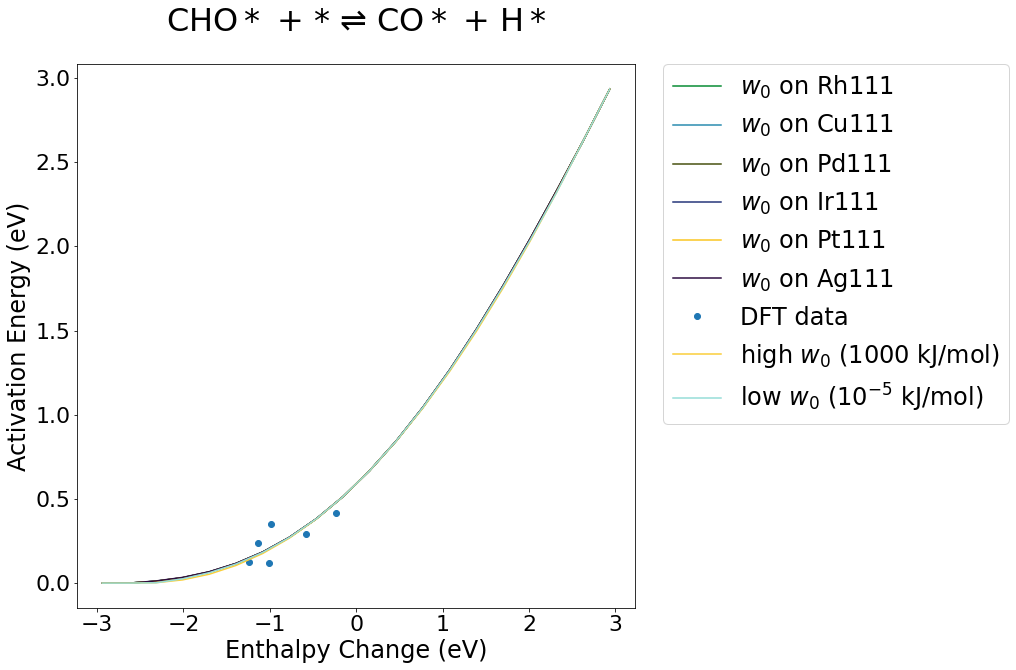

0

In [16]:
w0s = {}
metals = list(rxn_list[list(rxn_list.keys())[8]].keys()) # the value to be change should be the key index not the key
for i in range(len(metals)):
    w0s[metals[i]] = (abs(mdb.get_binding_energies(metals[i])['H'].value) + 4.25) * 96.4869 * 1e6 / 2# in J/kmol
bm_w0_spec_plot(rxn_list, list(rxn_list.keys())[8], w0s)

## Add w0 for H2O(5) + 2 X(1) <=> HX(21) + OHX(31)

80863237.337512 J/kmol


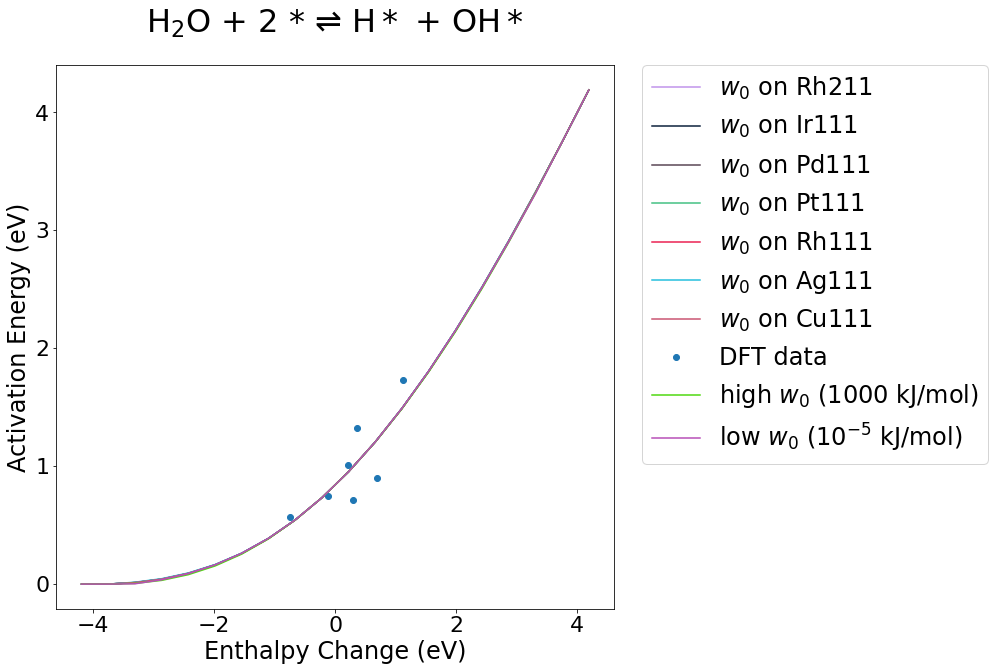

0

In [17]:
w0s = {}
metals = list(rxn_list[list(rxn_list.keys())[9]].keys()) # the value to be change should be the key index not the key
for i in range(len(metals)):
    w0s[metals[i]] = (abs(mdb.get_binding_energies(metals[i])['H'].value)+ abs(mdb.get_binding_energies(metals[i])['O'].value) + 4.77) * 96.4869 * 1e6 / 2# in J/kmol
bm_w0_spec_plot(rxn_list, list(rxn_list.keys())[9], w0s)

## Add w0 for C2H6(8) + 2 X(1) <=> 2 CH3X(27)

260105665.23707622 J/kmol


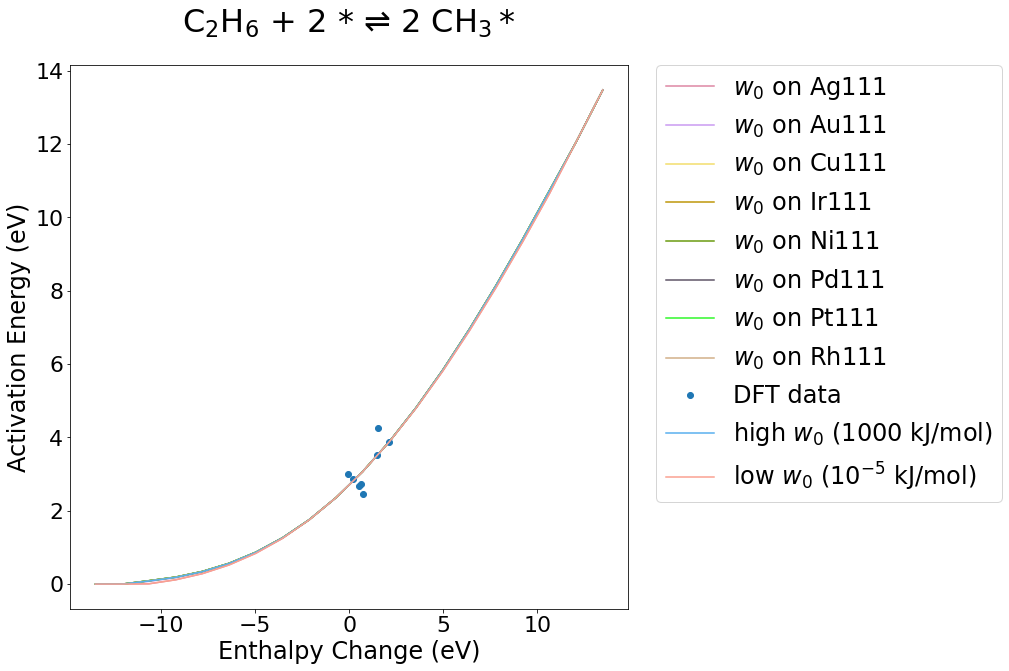

0

In [18]:
w0s = {}
metals = list(rxn_list[list(rxn_list.keys())[10]].keys()) # the value to be change should be the key index not the key
for i in range(len(metals)):
    w0s[metals[i]] = (abs(mdb.get_binding_energies(metals[i])['C'].value) * 2 + 3.69) * 96.4869 * 1e6 / 2# in J/kmol
bm_w0_spec_plot(rxn_list, list(rxn_list.keys())[10], w0s)

CHOX(234) + X(1) <=> COX(23) + HX(21) 
CH3OH(14) + 2 X(1) <=> CH3O_X(45) + HX(21) 
CH3O_X(45) + X(1) <=> CH2O_X(46) + HX(21) 
CH2O_X(46) + X(1) <=> CHOX(33) + HX(21) 

## Add w0 to CHOX(234) + X(1) <=> COX(23) + HX(21)

57292020.763072945 J/kmol


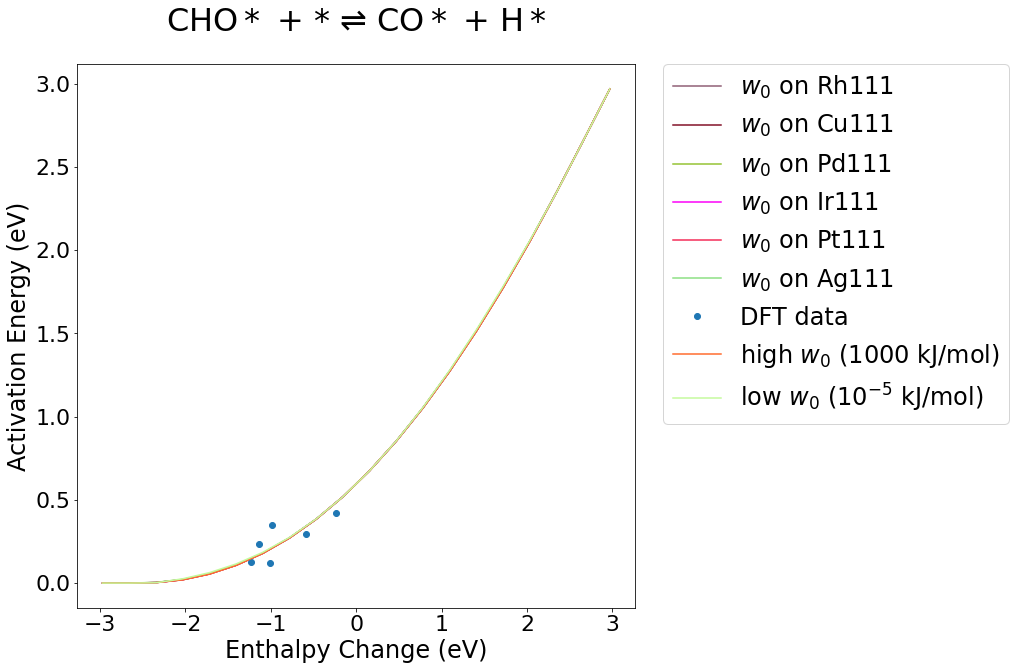

0

In [19]:
w0s = {}
metals = list(rxn_list[list(rxn_list.keys())[11]].keys()) # the value to be change should be the key index not the key
for i in range(len(metals)):
    w0s[metals[i]] = (abs(mdb.get_binding_energies(metals[i])['C'].value) + abs(mdb.get_binding_energies(metals[i])['H'].value) + 3.627 + 4.768) * 96.4869 * 1e6 / 2# in J/kmol
bm_w0_spec_plot(rxn_list, list(rxn_list.keys())[11], w0s)

56753519.72950543 J/kmol


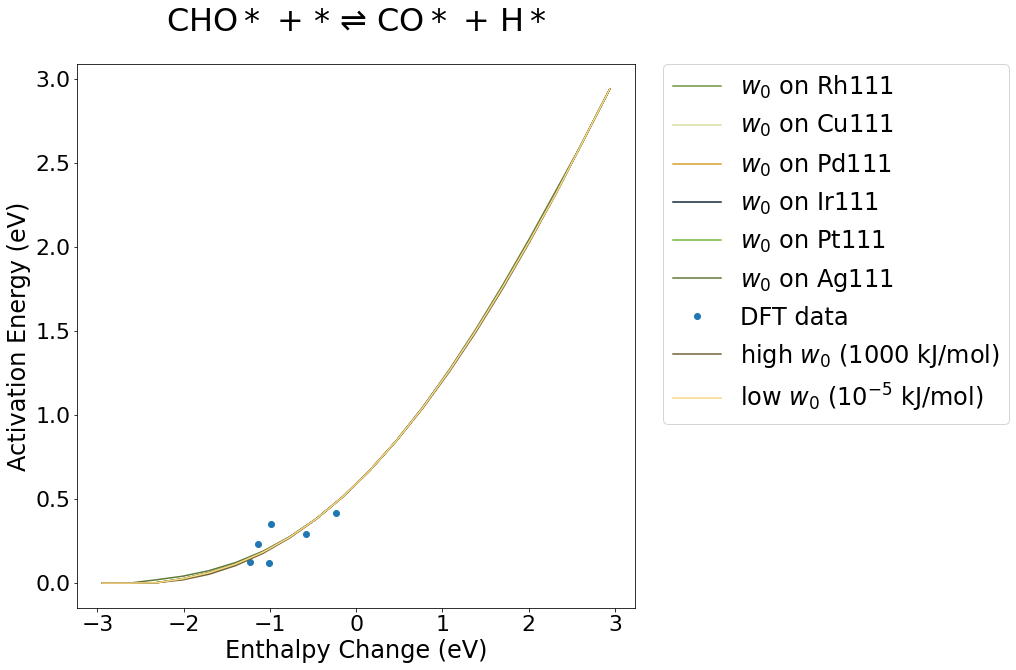

0

In [20]:
w0s = {}
metals = list(rxn_list[list(rxn_list.keys())[11]].keys()) # the value to be change should be the key index not the key
for i in range(len(metals)):
    w0s[metals[i]] =  rxn_list[list(rxn_list.keys())[11]][metals[i]][1] * i * 96.4869 * 1e6# in J/kmol
bm_w0_spec_plot(rxn_list, list(rxn_list.keys())[11], w0s)

## Check the input files

In [ ]:
rxns = fetch("""
            {reactions ( first: 200, surfaceComposition: "Cu", facet: "~111", reactants: "star+COgas", products: "COstar" ) 
            {
            totalCount
            pageInfo {
              hasNextPage
              hasPreviousPage
              startCursor
              endCursor
            }
            edges {
              node {
                Equation
                sites
                id
                pubId
                dftCode
                dftFunctional
                reactants
                products
                facet
                chemicalComposition
                facet
                reactionEnergy
                activationEnergy
                surfaceComposition
                chemicalComposition
                reactionSystems {
                  name
                  energyCorrection
                  aseId
                  systems{
                    energy
                    InputFile:"espresso-in"
                  }
                }
              }
            }
            }}
            """)

In [ ]:
for node in rxns['reactions']['edges']:
    rxn_system = node['node']['reactionSystems']
    for j, _ in enumerate(rxn_system):
            with io.StringIO() as tmp_file:
                sys = rxn_system[j]['systems']
                tmp_file.write(sys['InputFile'])
                tmp_file.seek(0)
                data, card_lines = read_fortran_namelist(tmp_file)
                
            with io.StringIO() as tmp_file:
                sys = rxn_system[j].pop('systems')
                tmp_file.write(sys.pop('InputFile'))
                tmp_file.seek(0)
#                 atoms = ase.io.read(tmp_file, format='json')
                atoms = read_espresso_in(tmp_file)
            calc_setting = {}
            calc_setting['data'] = data
            calc_setting['card_lines'] = card_lines[0:card_lines.index('CELL_PARAMETERS angstrom')]
            calculator = ase.calculators.singlepoint.SinglePointCalculator(
                atoms,
                energy=sys.pop('energy')
            )
            atoms.set_calculator(calculator)
            #print(atoms.get_potential_energy())
            rxn_system[j]['atoms'] = atoms
            rxn_system[j]['calculator'] = calc_setting
        # flatten list further into {name: atoms, ...} dictionary
    rxn_system = {x['name']: x['atoms'] for x in rxn_system}
rxns['reactions']['edges'][3]['node']

52473714.96013821 J/kmol
BM RMSE 0.1590911648933874
slope: [0.59311385] intercept: 58014023.36191116
BEP RMSE: 0.147014877769076


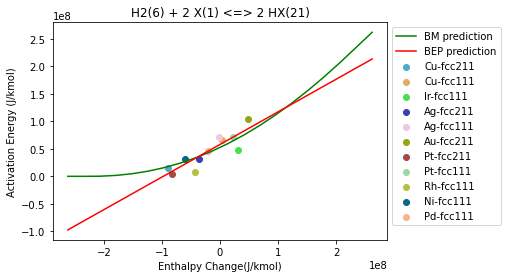

356838059.1355896 J/kmol
BM RMSE 1.2159534900627993
slope: [-0.71417605] intercept: 78910090.00254437
BEP RMSE: 0.17819700407032382


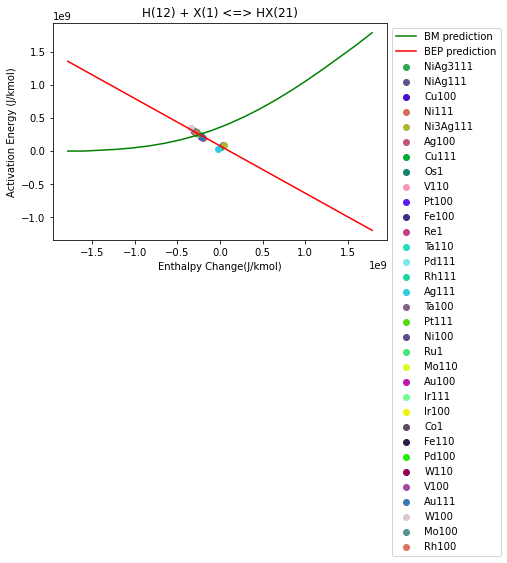

25051962.26275437 J/kmol
BM RMSE 0.0
slope: [0.] intercept: 0.0
BEP RMSE: 0.0


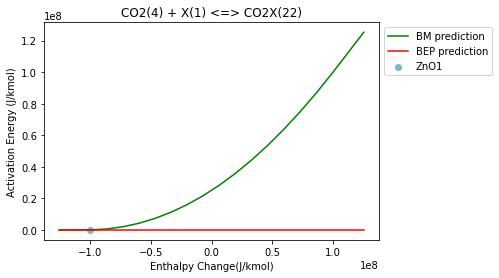

91622056.68337584 J/kmol
BM RMSE 0.1989743585243119
slope: [0.92034598] intercept: 67280022.74302556
BEP RMSE: 0.07362209966575395


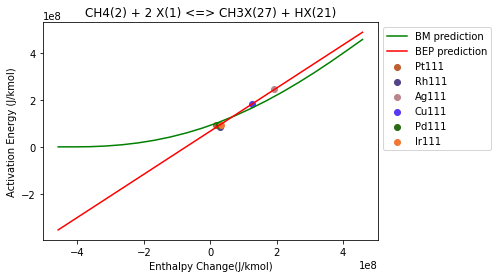

66013826.35976689 J/kmol
BM RMSE 9.992007221626409e-16
slope: [0.] intercept: 55320404.54680108
BEP RMSE: 0.0


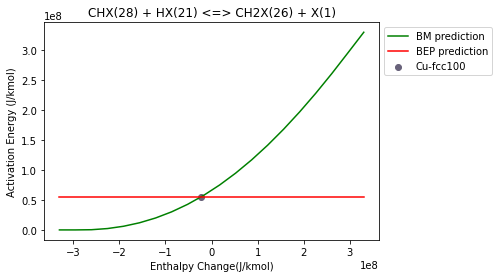

227411155.68531322 J/kmol
BM RMSE 0.011041927339642212
slope: [0.39933398] intercept: 220570318.1669929
BEP RMSE: 2.220446049250313e-16


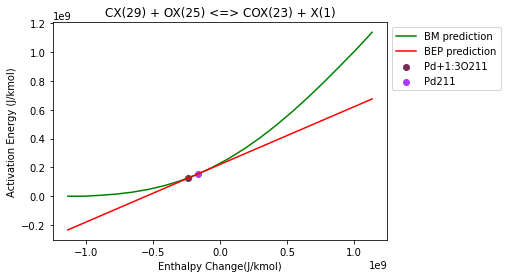

73679175.18045446 J/kmol
BM RMSE 2.220446049250313e-16
slope: [0.] intercept: 57431077.00503118
BEP RMSE: 0.0


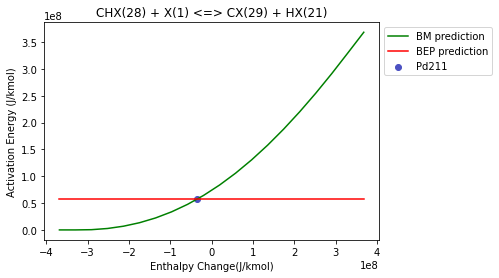

141852390.80201367 J/kmol
BM RMSE 0.13604349929446094
slope: [0.79733272] intercept: 180056032.18563277
BEP RMSE: 0.0


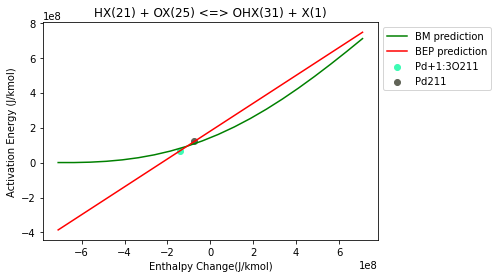

57354201.34479911 J/kmol
BM RMSE 0.07943906055122303
slope: [0.24407344] intercept: 45117630.08220685
BEP RMSE: 0.07078817224439513


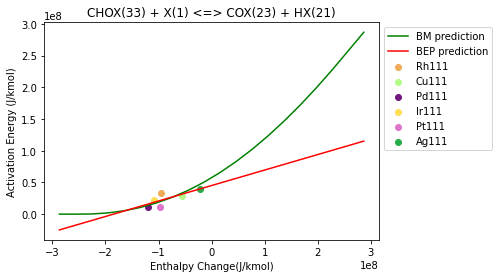

80994872.69763741 J/kmol
BM RMSE 0.2192687695166309
slope: [0.54328599] intercept: 82761105.2329794
BEP RMSE: 0.22981224450912877


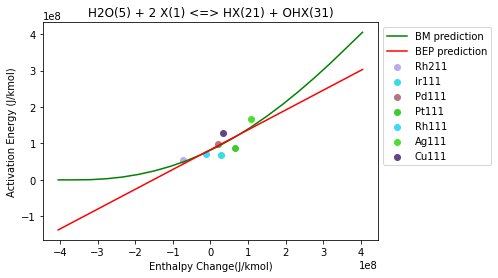

260014887.09579828 J/kmol
BM RMSE 0.3892449147951715
slope: [0.66493032] intercept: 249061109.60452652
BEP RMSE: 0.3860918977631976


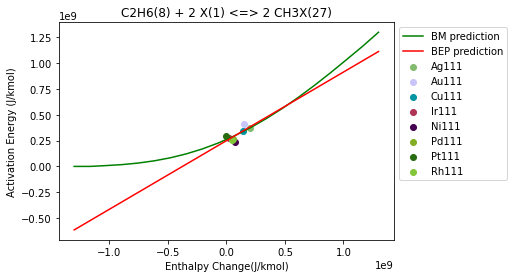

57354201.34479911 J/kmol
BM RMSE 0.07943906055122303
slope: [0.24407344] intercept: 45117630.08220685
BEP RMSE: 0.07078817224439513


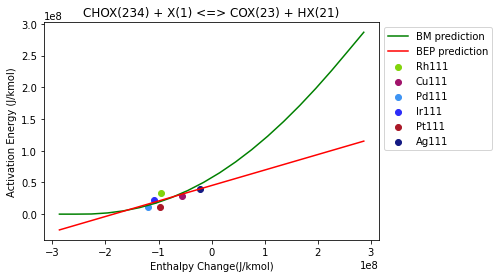

88852600.08934104 J/kmol
BM RMSE 0.20759031015828372
slope: [0.5001237] intercept: 90526481.00740035
BEP RMSE: 0.21163192359390023


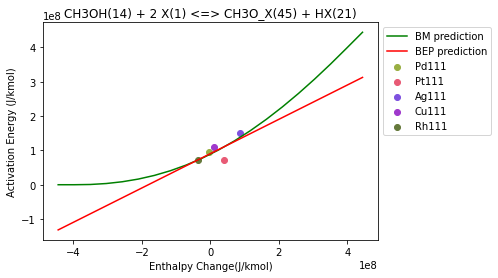

67098321.233405665 J/kmol
BM RMSE 0.12907588372265516
slope: [0.78827468] intercept: 59071344.82177922
BEP RMSE: 0.08714652292680067


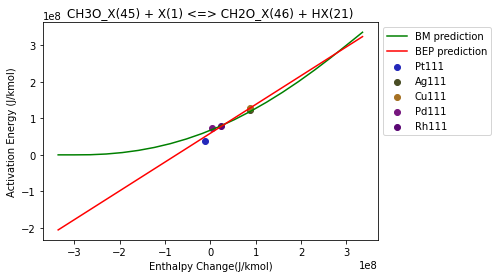

54587579.40640563 J/kmol
BM RMSE 0.10662981932908182
slope: [0.69691718] intercept: 59276970.48785214
BEP RMSE: 0.09293389747743322


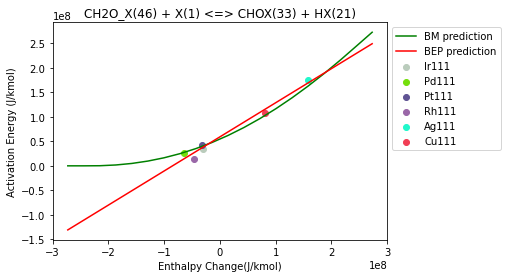

In [14]:
for i, v in rxn_list.items():
    intrinsic_Es = []
    for x, y in v.items():
        intrinsic_E = get_E0_from_Ea_dH(i, y[1]*96.4869e6, y[0]*96.4869e6, additional_point=v)
        intrinsic_Es.append(intrinsic_E)
#     intrinsic_Es = np.array(intrinsic_Es)
#     print(intrinsic_Es)
    E_0 = sum(intrinsic_Es) / len(intrinsic_Es)
#     E_0 = statistics.median(intrinsic_Es)
    print(E_0, "J/kmol")
    predicted_Es = []
    energies = []
    enthalpies = []
    predict_Es = []
    metals = []
    for x, y in v.items():
        energies.append(y[1]*96.4869e6)
        enthalpies.append(y[0]*96.4869e6)
        predict_Es.append(get_Ea_from_E0_dH(E_0, y[0]*96.4869e6))
        metals.append(x)
        
    for j in np.linspace(-5*E_0, 5*E_0, 20):
        predicted_Es.append(get_Ea_from_E0_dH(E_0, j))
        
    bm_rmse = sqrt(mean_squared_error(np.array(energies) / 96.4869e6, np.array(predict_Es) / 96.4869e6))
    print("BM RMSE", bm_rmse)
    plt.figure()
    plt.plot(np.linspace(-5*E_0, 5*E_0, 20), predicted_Es, '-g', label='BM prediction')
#     plt.plot(enthalpies, energies,'o', label='Cathub data')
    for a, txt in enumerate(metals):
        col = (np.random.random(), np.random.random(), np.random.random())
        plt.scatter(enthalpies[a], energies[a], c=[col], label=txt)
    np.array(enthalpies).reshape((-1, 1))
    reg = LinearRegression().fit(np.array(enthalpies).reshape((-1, 1)), np.array(energies))
    print('slope:', reg.coef_, 'intercept:', reg.intercept_)
    bep_energies = reg.coef_ * np.linspace(-5*E_0, 5*E_0, 20) + reg.intercept_
    plt.plot(np.linspace(-5*E_0, 5*E_0, 20), bep_energies, '-r', label='BEP prediction')
    BEP_RMSE = sqrt(mean_squared_error(np.array(energies) / 96.4869e6, (reg.coef_ * np.array(enthalpies) + reg.intercept_) / 96.4869e6))
    print('BEP RMSE:', BEP_RMSE)
    plt.xlabel("Enthalpy Change(J/kmol)")
    plt.ylabel("Activation Energy (J/kmol)")
    plt.title(surf.reaction(i))
    plt.legend(bbox_to_anchor = (1.0, 1.0))
    os.path.exists('cat_hub_plots') or os.mkdir('cat_hub_plots')
    plt.savefig(f'cat_hub_plots/rxn{i}.png', bbox_inches='tight')
    plt.show()